# DATA COLLECTION AND PORTFOLIO BUILDING STAGE

**NOTE: We strongly recommend that you read the README.md file first before going through the notebooks. The DATA DICTIONARY is available in the README.md or as a CSV file in the datasets folder.**

This notebook illustrates the process for data collection of the following:
- Company Fundamentals
- Analyst's Recommendations
- Market News
- Historical Prices

With the data collected from this data pipeline, we perform EDA to evaluate which are the important fundamental indicators that could help us in building a viable diversified portfolio. We will use the important fundamental indicators to help us build a portfolio using domain knowledge. We will also employ unsupervised learning techniques to build a "machine learning" portfolio for subsequent evaluation.

We will use VADER package to perform sentimental analysis for the news data as well. The output of the processes here will be several CSV files that contain the require datasets for the modeling stage.

Do note that there are various "checkpoints" in this notebook that export to backups folder and re-import from backups folder to preserve the continuity of our process explanation here. A simple accidental refresh of the kernel or accidental re-run will overwrite the data used in illustration and subsequent modeling stage. Therefore, we have to ensure that the same set of data is being used throughout the project.

## Importing packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re
import random
import time as ntime
import dateutil.relativedelta
import datetime
import requests
import yfinance as yf
import matplotlib.pyplot as plt

from urllib.request import urlopen
from urllib.request import Request
from bs4 import BeautifulSoup

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# setting some parameters
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
pd.options.mode.chained_assignment = None

## Importing companies tickers list

There are over 7.5K companies listed in the US major exchanges. We are only interested to consider companies that have market capitalization of USD 10 billion or above (i.e. minimally large-cap companies). By simply filtering based on this criteria, we are still left with 800+ companies to work with.

We will be importing a CSV file containing the 800+ companies tickers that was obtained from finviz.com screener page.

We will need to obtain additional information for these companies and perform further filtering to a manageable number of companies before we proceed with the rest of the data collection processes.

In [2]:
# All large cap over 10bil market capitalization companies listed in US
tickers_list_df = pd.read_csv('datasets/over10bil_largecap.csv')
print(tickers_list_df.shape)
tickers_list_df.sample(frac=1).head()

(842, 1)


,ticker
693,SU
635,RMD
669,SMFG
748,TXN
330,GGG


## PART 1 - DATA COLLECTION

### Scrapping Fundamentals Indicators

**Why did we choose to only scrape finviz.com?**

finviz.com contain market information from many other investment related websites such as Yahoo Finance, Bloomberg, Benzinga, Motley Fool, The Independent, The Guardian, SmarterAnalyst, Investor's Business Daily, etc just to name a few.

finviz.com also consolidated many financial analyst's recommendations on companies, this save us a lot of time to build scrapping bots for each analyst firms' websites.

On top of these, each company's fundamental indicators snapshots are readily available on finviz.com.

The best part is that the abundance of data are updated frequently and presented in a "scrape friendly" format. This save us a lot of time building codes and navigating the javascript tricks, paywalls and captcha tricks that prevent scrapping.

After trying to directly scrape from numerous websites and failing to get pass the "scrape blocking techniques". We decided to use finviz.com as the main source for its quantity and quality data.

For every scrapping attempt, we shall write the codes to test for one company to ensure we can get the require data before building and running a loop. The identification of what tags to search for was done using the `inspect element` function that is built into Google Chrome browser.

In [3]:
# pinging target using Facebook, ticker = FB
ticker = 'FB'
url = 'https://finviz.com/quote.ashx?t='+ticker

res = Request(url,headers={'user-agent': 'money datascientist'})
resp = urlopen(res)
soup = BeautifulSoup(resp, features="lxml")
soup

<!DOCTYPE html>
<html>
<head>
<title>FB Facebook, Inc. Stock Quote</title>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=1024" name="viewport"/><meta content="Stock screener for investors and traders, financial visualizations." name="description"/>
<meta content="Stock Screener, Charts, Quotes, Maps, News, Financial Visualizations, Research, Trading Systems" name="keywords"/>
<meta content="no" http-equiv="imagetoolbar"/>
<meta content="no-cache" http-equiv="pragma"/>
<meta content="no-cache" http-equiv="cache-control"/>
<meta content="-1" http-equiv="Expires"/>
<link as="font" crossorigin="" href="/fonts/lato-v17-latin-ext_latin-regular.woff2" rel="preload"/>
<link as="font" crossorigin="" href="/fonts/lato-v17-latin-ext_latin-700.woff2" rel="preload"/>
<link href="/css/finviz.css?rev=154" rel="stylesheet" type="text/css"/>
<link href="/favicon_2x.png" rel="icon" sizes="32x32" type="image/png"/>
<link href="/favicon.png" rel="icon" sizes="16x16" type="ima

In [4]:
# find target tags for comp_name, sector and industry
target = soup.find_all('a', attrs = {'class': 'tab-link'})
target

[<a class="tab-link" href="javascript:void(0)" id="publish-chart">publish chart</a>,
 <a class="tab-link" href="/save_to_portfolio.ashx?t=FB">save to portfolio</a>,
 <a class="tab-link" href="/create_alert.ashx?t=FB">create alert</a>,
 <a class="tab-link" href="quote.ashx?t=FB&amp;ty=c&amp;ta=0&amp;p=d">candle</a>,
 <a class="tab-link" href="quote.ashx?t=FB&amp;ty=l&amp;ta=0&amp;p=d">line</a>,
 <a class="tab-link" href="quote.ashx?t=FB&amp;ty=c&amp;ta=1&amp;p=d"><b>advanced</b></a>,
 <a class="tab-link" href="/elite.ashx">interactive</a>,
 <a class="tab-link" href="/elite.ashx">perf</a>,
 <a class="tab-link" href="elite.ashx">intraday</a>,
 <a class="tab-link" href="quote.ashx?t=FB&amp;ty=c&amp;ta=1&amp;p=d"><b>daily</b></a>,
 <a class="tab-link" href="quote.ashx?t=FB&amp;ty=c&amp;ta=0&amp;p=w">weekly</a>,
 <a class="tab-link" href="quote.ashx?t=FB&amp;ty=c&amp;ta=0&amp;p=m">monthly</a>,
 <a class="tab-link" href="http://investor.fb.com" target="_blank"><b>Facebook, Inc.</b></a>,
 <a c

In [5]:
# find comp_name which is in position [12] from above output
comp_name = target[12].text
comp_name

'Facebook, Inc.'

In [6]:
# find sector which is in position [13] from above output
sector = target[13].text
sector

'Communication Services'

In [7]:
# find industry which is in position [14] from above output
industry = target[14].text
industry

'Internet Content & Information'

In [8]:
# find indicators tags by searching for table attribute of {'class' : 'snapshot-td2-cp'} that we
# identify from Chrome 'inspect element' function
target_ind = soup.find_all('td', attrs ={'class' : 'snapshot-td2-cp'})
target_ind

[<td align="left" class="snapshot-td2-cp" title="cssbody=[tooltip_short_bdy] cssheader=[tooltip_short_hdr] body=[Major index membership] offsetx=[10] offsety=[20] delay=[300]" width="7%">Index</td>,
 <td align="left" class="snapshot-td2-cp" title="cssbody=[tooltip_short_bdy] cssheader=[tooltip_short_hdr] body=[Price-to-Earnings (ttm)] offsetx=[10] offsety=[20] delay=[300]" width="7%">P/E</td>,
 <td align="left" class="snapshot-td2-cp" title="cssbody=[tooltip_short_bdy] cssheader=[tooltip_short_hdr] body=[Diluted EPS (ttm)] offsetx=[10] offsety=[20] delay=[300]" width="7%">EPS (ttm)</td>,
 <td align="left" class="snapshot-td2-cp" title="cssbody=[tooltip_short_bdy] cssheader=[tooltip_short_hdr] body=[Insider ownership] offsetx=[10] offsety=[20] delay=[300]" width="7%">Insider Own</td>,
 <td align="left" class="snapshot-td2-cp" title="cssbody=[tooltip_short_bdy] cssheader=[tooltip_short_hdr] body=[Shares outstanding] offsetx=[10] offsety=[20] delay=[300]" width="7%">Shs Outstand</td>,
 <t

In [9]:
# confirm the text is what we need
print(target_ind[0].text)
print(target_ind[13].text)
print(target_ind[25].text)

Index
PEG
P/B


In [10]:
# check how many fundamental indicators available
len(target_ind)

72

In [11]:
# find target indicator values using 'attrs ={'class' : 'snapshot-td2'}
target_val = soup.find_all('td', attrs ={'class' : 'snapshot-td2'})
target_val

[<td align="left" class="snapshot-td2" width="8%"><b>S&amp;P 500</b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b>32.36</b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b>8.43</b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b>0.63%</b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b>2.85B</b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b><span class="is-green">8.44%</span></b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b>759.53B</b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b>26.00</b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b>10.50</b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b>-13.13%</b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b>2.39B</b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b><span class="is-red">-1.28%</span></b></td>,
 <td align="left" class="snapshot-td2" width="8%"><b>25.28B</b></td>,
 <td align="left" class="snapshot-

In [12]:
# confirm the text is what we need
print(target_val[0].text)
print(target_val[15].text)
print(target_val[32].text)

S&P 500
79.80%
16.60%


In [13]:
# check how many values available and it should match target_ind length
len(target_val)

72

In [14]:
# extracting each row and put into a df
one_comp_list=[]
ind_list=[]
val_list=[]

target_ind = soup.find_all('td', attrs ={'class' : 'snapshot-td2-cp'})
target_val = soup.find_all('td', attrs ={'class' : 'snapshot-td2'})
for i in range(len(target_ind)):
    ind = target_ind[i].text
    val = target_val[i].text
    ind_list.append(ind)
    val_list.append(val)

val_df = pd.DataFrame(val_list, index=ind_list).T
val_df['ticker'] = ticker
val_df['name'] = comp_name
val_df['sector'] = sector
val_df['industry'] = industry
val_df

,Index,P/E,EPS (ttm),Insider Own,Shs Outstand,Perf Week,Market Cap,Forward P/E,EPS next Y,Insider Trans,Shs Float,Perf Month,Income,PEG,EPS next Q,Inst Own,Short Float,Perf Quarter,Sales,P/S,EPS this Y,Inst Trans,Short Ratio,Perf Half Y,Book/sh,...,Oper. Margin,RSI (14),Volatility,Optionable,Debt/Eq,EPS Q/Q,Profit Margin,Rel Volume,Prev Close,Shortable,LT Debt/Eq,Earnings,Payout,Avg Volume,Price,Recom,SMA20,SMA50,SMA200,Volume,Change,ticker,name,sector,industry
0,S&P 500,32.36,8.43,0.63%,2.85B,8.44%,759.53B,26.0,10.5,-13.13%,2.39B,-1.28%,25.28B,1.95,3.19,79.80%,0.98%,1.98%,78.98B,9.62,-15.10%,0.05%,1.23,13.76%,41.31,...,36.40%,58.3,3.11% 2.72%,Yes,0.0,28.10%,32.00%,1.84,272.87,Yes,0.0,Jan 27 AMC,0.00%,19.10M,277.17,1.8,4.61%,1.86%,10.95%,"5,683,059",1.58%,FB,"Facebook, Inc.",Communication Services,Internet Content & Information


#### Making a loop for mass extraction

Once the above was confirmed, we defined a loop to mass extract data.

In [15]:
# mass scrapping loop function
fail_tickers = []

def fundamental_indicators_scrape(ticker):
    try:
        url = 'https://finviz.com/quote.ashx?t='+ticker
        res = Request(url,headers={'user-agent': 'money datascientist'})
        resp = urlopen(res)
        status_code = resp.getcode()
        if status_code != 200:
            print('error', status_code, url)
            pass
        else:    
            print('trying', url)
            soup = BeautifulSoup(resp, features="lxml")

            # extracting comp_name, sector and industry
            target = soup.find_all('a', attrs = {'class': 'tab-link'})
            # find comp_name
            comp_name = target[12].text
            # find sector
            sector = target[13].text
            # find industry
            industry = target[14].text

            # extracting each row and put into a df
            ind_list=[]
            val_list=[]

            target_ind = soup.find_all('td', attrs ={'class' : 'snapshot-td2-cp'})
            target_val = soup.find_all('td', attrs ={'class' : 'snapshot-td2'})

            for i in range(len(target_ind)):
                ind = target_ind[i].text
                val = target_val[i].text
                ind_list.append(ind)
                val_list.append(val)

                val_df = pd.DataFrame(val_list, index=ind_list).T
                val_df['ticker'] = ticker
                val_df['name'] = comp_name
                val_df['sector'] = sector
                val_df['industry'] = industry
    except:
        print('Fail', ticker)
        fail_tickers.append(ticker)
        pass
    
    return val_df

In [16]:
# call the function, iterate for all tickers and append each ticker result to one df
i = 0
for ticker in tickers_list_df['ticker']:
    if i==0:
        all_comp_df = fundamental_indicators_scrape(ticker)
        i+=1
    else:
        all_comp_df = all_comp_df.append(fundamental_indicators_scrape(ticker))
    
    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(1,2)
    ntime.sleep(sleep_duration)
    print('Success', ticker, 'sleep', sleep_duration)

all_comp_df.reset_index(drop=True, inplace=True)

trying https://finviz.com/quote.ashx?t=A
Success A sleep 1
trying https://finviz.com/quote.ashx?t=AAP
Success AAP sleep 1
trying https://finviz.com/quote.ashx?t=AAPL
Success AAPL sleep 2
trying https://finviz.com/quote.ashx?t=AAXN
Success AAXN sleep 1
trying https://finviz.com/quote.ashx?t=ABB
Success ABB sleep 1
trying https://finviz.com/quote.ashx?t=ABBV


KeyboardInterrupt: 

**NOTE: The error message above (if any) was due to a manual interruption to the code execution. The codes work perfectly, it was manually interrupted because we have to run this notebook again after a kernel refresh to generate the in-notebook visuals to go with the textual explanation of how this works. The desire results were obtained in previous full run and were exported to CSV files for subsequent steps.**

In [17]:
# checking if any tickers failed
print('Failed tickers = ', fail_tickers)

Failed tickers =  []


**NOTE: The "Failed tickers" (if any) reported above was due to a manual interruption to the code execution. The codes work perfectly, it was manually interrupted because we have to run this notebook again after a kernel refresh to generate the in-notebook visuals to go with the textual explanation of how this works. The desire results (with no fail tickers) were obtained in previous full run and were exported to CSV files for subsequent steps.**

**NOTE: Some codes below are commented out to prevent accidental execution that will overwrite the previously extracted data used for the rest of this project.**

In [18]:
# exporting result to csv file
#all_comp_df.to_csv('datasets/fundamental_indicators.csv', index=False)

In [19]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#all_comp_df.to_csv('datasets/backups/fundamental_indicators.csv', index=False)

In [1]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
#all_comp_df = pd.read_csv('datasets/backups/fundamental_indicators.csv')

NameError: name 'pd' is not defined

### Updating tickers list with additional information

In [4]:
# create new df with additional info
add_info_df = all_comp_df[['ticker', 'name', 'sector', 'industry']]

In [5]:
# create new columns in previous tickers df and mapping to new additional info
tickers_list_df['name'] = tickers_list_df['ticker'].map(add_info_df.set_index('ticker')['name'])
tickers_list_df['sector'] = tickers_list_df['ticker'].map(add_info_df.set_index('ticker')['sector'])
tickers_list_df['industry'] = tickers_list_df['ticker'].map(add_info_df.set_index('ticker')['industry'])

In [6]:
# preview
print(tickers_list_df.shape)
tickers_list_df.head()

(842, 4)


,ticker,name,sector,industry
0,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research
1,AAP,"Advance Auto Parts, Inc.",Consumer Cyclical,Specialty Retail
2,AAPL,Apple Inc.,Technology,Consumer Electronics
3,AAXN,"Axon Enterprise, Inc.",Industrials,Aerospace & Defense
4,ABB,ABB Ltd,Industrials,Specialty Industrial Machinery


In [7]:
# check for null
tickers_list_df.isnull().sum()

ticker      0
name        0
sector      0
industry    0
dtype: int64

**NOTE: The "nulls" reported above (if any) was due to a manual interruption to the code execution. The codes work perfectly, it was manually interrupted because we have to run this notebook again after a kernel refresh to generate the in-notebook visuals to go with the textual explanation of how this works. The desire results were obtained in previous full run and were exported to CSV files for subsequent steps.**

In [25]:
# export updated list to csv to be used for other steps
#tickers_list_df.to_csv('datasets/updated_tickers_list.csv', index=False)

In [26]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#tickers_list_df.to_csv('datasets/backups/updated_tickers_list.csv', index=False)

In [ ]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
tickers_list_df = pd.read_csv('datasets/backups/updated_tickers_list.csv')

## PART 1 DATA CLEANING AND EDA

With the fundamental information of 800+ companies, we shall attempt to build a diversified portfolio of companies. Traditionally, this is accomplish through financial investment and market domain knowledge. However, in this project we shall build both a domain knowledge portfolio as well as an unsupervised machine learning portfolio.

In order to reduce the processing time to extract data for 800+ companies. We will have to establish the various portfolios and will only extract the data for those companies within the portfolios. We shall start with the domain knowledge portfolio but we will need to do some data cleaning and EDA to narrow down to selection using the important indicators only, much like how an investor would do.

### Data Cleaning

In [9]:
# importing the previously saved complete data from the scrapping process
fundamental_df = pd.read_csv('datasets/backups/fundamental_indicators.csv')
print(fundamental_df.shape)
fundamental_df.head()

(842, 76)


,Index,P/E,EPS (ttm),Insider Own,Shs Outstand,Perf Week,Market Cap,Forward P/E,EPS next Y,Insider Trans,Shs Float,Perf Month,Income,PEG,EPS next Q,Inst Own,Short Float,Perf Quarter,Sales,P/S,EPS this Y,Inst Trans,Short Ratio,Perf Half Y,Book/sh,...,Oper. Margin,RSI (14),Volatility,Optionable,Debt/Eq,EPS Q/Q,Profit Margin,Rel Volume,Prev Close,Shortable,LT Debt/Eq,Earnings,Payout,Avg Volume,Price,Recom,SMA20,SMA50,SMA200,Volume,Change,ticker,name,sector,industry
0,S&P 500,55.17,2.30,0.40%,309.00M,0.02%,38.91B,30.44,4.17,-15.97%,304.40M,6.45%,719.00M,5.93,0.89,90.10%,0.82%,20.25%,5.34B,7.29,-31.60%,0.10%,1.42,31.81%,15.77,...,15.80%,68.39,1.62% 1.89%,Yes,0.48,14.40%,13.50%,0.77,128.11,Yes,0.47,Nov 23 AMC,30.30%,1.76M,127.00,2.2,3.89%,8.35%,28.81%,"1,612,125",-0.87%,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research
1,S&P 500,24.25,6.87,0.20%,68.97M,-2.96%,11.55B,17.53,9.51,0.00%,67.60M,4.18%,476.90M,2.12,1.96,-,4.16%,8.93%,9.85B,1.17,21.10%,0.01%,2.94,11.57%,54.56,...,6.90%,56.45,2.08% 2.41%,Yes,0.00,21.70%,4.80%,0.48,165.18,Yes,0.27,Nov 10 BMO,12.60%,955.51K,166.68,2.3,1.83%,5.90%,13.94%,"472,060",0.91%,AAP,"Advance Auto Parts, Inc.",Consumer Cyclical,Specialty Retail
2,DJIA S&P500,41.89,3.27,0.07%,17.06B,4.57%,2334.66B,31.33,4.37,-6.96%,16.63B,8.07%,57.41B,3.24,1.40,60.30%,0.55%,16.48%,274.52B,8.50,10.20%,-0.04%,0.84,40.71%,3.83,...,24.10%,63.18,2.66% 2.70%,Yes,1.73,-3.00%,20.90%,1.10,132.03,Yes,1.52,Jan 27 AMC,24.10%,108.47M,136.87,2.0,4.66%,9.70%,30.75%,"120,529,544",3.67%,AAPL,Apple Inc.,Technology,Consumer Electronics
3,-,-,-0.66,0.90%,63.50M,11.90%,10.25B,125.13,1.30,-36.59%,62.82M,29.68%,-39.90M,-,0.35,88.40%,4.55%,53.24%,626.70M,16.36,-97.10%,0.03%,4.73,82.38%,14.10,...,-5.50%,78.10,5.44% 4.71%,Yes,0.00,-113.50%,-6.40%,1.41,164.56,Yes,0.00,Nov 05 AMC,-,605.42K,162.54,2.2,22.48%,27.87%,67.11%,"873,372",-1.23%,AAXN,"Axon Enterprise, Inc.",Industrials,Aerospace & Defense
4,-,135.25,0.22,-,2.12B,-0.36%,68.15B,-,-,-,1.95B,10.44%,481.00M,9.26,-,4.80%,0.28%,12.83%,26.02B,2.62,-27.90%,-0.02%,3.04,15.11%,7.90,...,6.40%,64.92,1.22% 1.29%,Yes,0.52,-221.10%,21.30%,0.98,29.75,Yes,0.38,Feb 04 BMO,30.10%,1.82M,30.16,2.2,4.27%,8.78%,24.17%,"1,767,800",1.38%,ABB,ABB Ltd,Industrials,Specialty Industrial Machinery


**Note:** All the indicators' values should be in float as they are financial representative numbers. We wrote a code to convert data types to float and any failed conversion indicated that there are values in the indicators columns that are in the wrong data type (e.g. alphabets, special characters, etc).

All the percentage denominated indicators will not be necessary since these are derived from static values in other indicators.

The few exceptions will be the `ticker`, `name`, `sector`, `industry` indicators that are meant to be object type.

In [41]:
# check datatype and return those that are unable to convert to float dtype
# the only allowable features reported should be ticker, name, sector, industry which are objects
# everything else reported have some characters in the values that prevent it from being converted
col_list = fundamental_df.columns.tolist()
for col in col_list:
    try:
        fundamental_df[col] = fundamental_df[col].astype('float64')
    except:
        print('wrong type', col)

wrong type Index
wrong type P/E
wrong type EPS (ttm)
wrong type Insider Own
wrong type Shs Outstand
wrong type Perf Week
wrong type Market Cap
wrong type Forward P/E
wrong type EPS next Y
wrong type Insider Trans
wrong type Shs Float
wrong type Perf Month
wrong type Income
wrong type PEG
wrong type EPS next Q
wrong type Inst Own
wrong type Short Float
wrong type Perf Quarter
wrong type Sales
wrong type P/S
wrong type EPS this Y
wrong type Inst Trans
wrong type Short Ratio
wrong type Perf Half Y
wrong type Book/sh
wrong type P/B
wrong type EPS next Y.1
wrong type ROA
wrong type Target Price
wrong type Perf Year
wrong type Cash/sh
wrong type P/C
wrong type EPS next 5Y
wrong type ROE
wrong type 52W Range
wrong type Perf YTD
wrong type Dividend
wrong type P/FCF
wrong type EPS past 5Y
wrong type ROI
wrong type 52W High
wrong type Beta
wrong type Dividend %
wrong type Quick Ratio
wrong type Sales past 5Y
wrong type Gross Margin
wrong type 52W Low
wrong type Employees
wrong type Current Ratio

In [42]:
# remove % sign and changing column name to reflect it as a percentage variable
fundamental_df.replace('\%', '', regex=True, inplace=True)
fundamental_df.rename(columns={'Insider Own':'Insider Own pct', 'Perf Week':'Perf Week pct',
                               'Insider Trans':'Insider Trans pct', 'Perf Month':'Perf Month pct',
                               'Inst Own':'Inst Own pct', 'Short Float':'Short Float pct',
                               'Perf Quarter':'Perf Quarter pct', 'EPS this Y':'EPS this Y pct',
                               'Inst Trans':'Inst Trans pct', 'Perf Half Y':'Perf Half Y pct',
                               'EPS next Y.1':'EPS next Y pct', 'ROA':'ROA pct',
                               'Perf Year':'Perf Year pct', 'EPS next 5Y':'EPS next 5Y pct',
                               'ROE':'ROE pct', 'Perf YTD':'Perf YTD pct', 'EPS past 5Y':'EPS past 5Y pct',
                               'ROI':'ROI pct', '52W High':'52W High pct', 'Dividend %':'Dividend pct',
                               'Sales past 5Y':'Sales past 5Y pct', 'Gross Margin':'Gross Margin pct',
                               '52W Low':'52W Low pct', 'Sales Q/Q':'Sales Q/Q pct',
                               'Oper. Margin':'Oper Margin pct', 'Volatility':'Volatility pct',
                               'EPS Q/Q':'EPS Q/Q pct', 'Profit Margin':'Profit Margin pct',
                               'Payout':'Payout pct', 'SMA20':'SMA20 pct', 'SMA50':'SMA50 pct',
                               'SMA200':'SMA200 pct', 'Change':'Change pct',}, inplace=True)

In [43]:
# define function to convert strings in billion, million and thousands to numbers
def bil_mil_convert(text):
    if 'B' in text:
        text = text.replace('B','')
        text = float(text)
        text = text*(10**9)
    elif 'M' in text:
        text = text.replace('M','')
        text = float(text)
        text = text*(10**6)
    elif 'K' in text:
        text = text.replace('K','')
        text = float(text)
        text = text*(10**3)
    return text

In [44]:
# convert strings in billion and million to numbers
fundamental_df['Shs Outstand'] = fundamental_df['Shs Outstand'].apply(bil_mil_convert)
fundamental_df['Market Cap'] = fundamental_df['Market Cap'].apply(bil_mil_convert)
fundamental_df['Shs Float'] = fundamental_df['Shs Float'].apply(bil_mil_convert)
fundamental_df['Income'] = fundamental_df['Income'].apply(bil_mil_convert)
fundamental_df['Sales'] = fundamental_df['Sales'].apply(bil_mil_convert)
fundamental_df['Avg Volume'] = fundamental_df['Avg Volume'].apply(bil_mil_convert)
fundamental_df.head()

# replace '-' with NaN for isnull detection later
fundamental_df.replace('-', np.NaN, inplace=True)

# replace comma in values
fundamental_df['Volume'] = fundamental_df['Volume'].apply(lambda x: re.sub('\D','', x))

**Note:** Applying domain knowledge on some of the indicators, we shall drop those that we know will not be useful in helping us build a portfolio.

In [45]:
# drop unnecessary columns
col_to_drop = ['Index', 'Employees', 'Optionable', 'Shortable', 'Recom', 'Earnings', 'Inst Trans pct',
               '52W Range', '52W Low pct', '52W High pct', 'Avg Volume', 'Rel Volume', 'Perf Week pct',
               'Perf Month pct', 'Perf Quarter pct', 'Perf Half Y pct', 'Perf Year pct', 'Perf YTD pct',
               'Volatility pct', 'Prev Close', 'Change pct', 'Target Price']
fundamental_df.drop(labels=col_to_drop, axis=1, inplace=True)
fundamental_df.head()

,P/E,EPS (ttm),Insider Own pct,Shs Outstand,Market Cap,Forward P/E,EPS next Y,Insider Trans pct,Shs Float,Income,PEG,EPS next Q,Inst Own pct,Short Float pct,Sales,P/S,EPS this Y pct,Short Ratio,Book/sh,P/B,EPS next Y pct,ROA pct,Cash/sh,P/C,EPS next 5Y pct,...,ROI pct,Beta,Dividend pct,Quick Ratio,Sales past 5Y pct,Gross Margin pct,ATR,Current Ratio,Sales Q/Q pct,Oper Margin pct,RSI (14),Debt/Eq,EPS Q/Q pct,Profit Margin pct,LT Debt/Eq,Payout pct,Price,SMA20 pct,SMA50 pct,SMA200 pct,Volume,ticker,name,sector,industry
0,55.17,2.30,0.40,3.090000e+08,3.891000e+10,30.44,4.17,-15.97,3.044000e+08,7.190000e+08,5.93,0.89,90.1,0.82,5.340000e+09,7.29,-31.6,1.42,15.77,8.05,12.88,7.5,4.70,27.00,9.30,...,10.0,1.02,0.61,1.8,5.7,53.1,2.32,2.3,8.5,15.8,68.39,0.48,14.4,13.5,0.47,30.3,127.00,3.89,8.35,28.81,1612125,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research
1,24.25,6.87,0.20,6.897000e+07,1.155000e+10,17.53,9.51,0.00,6.760000e+07,4.769000e+08,2.12,1.96,NaN,4.16,9.850000e+09,1.17,21.1,2.94,54.56,3.05,10.76,4.0,15.41,10.82,11.45,...,12.3,1.32,0.60,0.4,-0.3,43.9,4.02,1.4,9.9,6.9,56.45,0.00,21.7,4.8,0.27,12.6,166.68,1.83,5.90,13.94,472060,AAP,"Advance Auto Parts, Inc.",Consumer Cyclical,Specialty Retail
2,41.89,3.27,0.07,1.706000e+10,2.334660e+12,31.33,4.37,-6.96,1.663000e+10,5.741000e+10,3.24,1.40,60.3,0.55,2.745200e+11,8.50,10.2,0.84,3.83,35.74,8.85,17.6,5.33,25.67,12.92,...,31.7,1.27,0.60,1.3,3.3,38.2,3.75,1.4,1.0,24.1,63.18,1.73,-3.0,20.9,1.52,24.1,136.87,4.66,9.70,30.75,120529544,AAPL,Apple Inc.,Technology,Consumer Electronics
3,NaN,-0.66,0.90,6.350000e+07,1.025000e+10,125.13,1.30,-36.59,6.282000e+07,-3.990000e+07,NaN,0.35,88.4,4.55,6.267000e+08,16.36,-97.1,4.73,14.10,11.53,16.82,-3.8,8.04,20.22,18.80,...,-1.4,0.55,NaN,3.0,26.4,58.7,7.03,3.4,27.2,-5.5,78.10,0.00,-113.5,-6.4,0.00,NaN,162.54,22.48,27.87,67.11,873372,AAXN,"Axon Enterprise, Inc.",Industrials,Aerospace & Defense
4,135.25,0.22,NaN,2.120000e+09,6.815000e+10,NaN,NaN,NaN,1.950000e+09,4.810000e+08,9.26,NaN,4.8,0.28,2.602000e+10,2.62,-27.9,3.04,7.90,3.82,NaN,12.0,3.82,7.89,14.60,...,5.2,1.11,2.75,1.1,-6.8,30.7,0.50,1.4,-4.5,6.4,64.92,0.52,-221.1,21.3,0.38,30.1,30.16,4.27,8.78,24.17,1767800,ABB,ABB Ltd,Industrials,Specialty Industrial Machinery


In [46]:
# check if there is any more data type errors
col_list = fundamental_df.columns.tolist()
for col in col_list:
    try:
        fundamental_df[col] = fundamental_df[col].astype('float64')
    except:
        print('wrong type', col)
# the failed columns should be object, so it is okay

wrong type ticker
wrong type name
wrong type sector
wrong type industry


**Note:** Based on our domain knowledge of the remaining indicators and their meaning. We know how difficult it is to obtain any missing numbers. We feel that it will be improper to impute financial numbers in any way. Moreover, with 800+ companies it is still too many to be considered for any investment portfolio. Thus, we shall drop all NaN rows.

In [47]:
# drop all rows with NaN and confirm no NaN anymore
fundamental_df.dropna(axis=0, inplace=True)
fundamental_df.reset_index(drop=True, inplace=True)
print(fundamental_df.shape)
fundamental_df.isnull().sum()

(197, 54)


P/E                  0
EPS (ttm)            0
Insider Own pct      0
Shs Outstand         0
Market Cap           0
Forward P/E          0
EPS next Y           0
Insider Trans pct    0
Shs Float            0
Income               0
PEG                  0
EPS next Q           0
Inst Own pct         0
Short Float pct      0
Sales                0
P/S                  0
EPS this Y pct       0
Short Ratio          0
Book/sh              0
P/B                  0
EPS next Y pct       0
ROA pct              0
Cash/sh              0
P/C                  0
EPS next 5Y pct      0
ROE pct              0
Dividend             0
P/FCF                0
EPS past 5Y pct      0
ROI pct              0
Beta                 0
Dividend pct         0
Quick Ratio          0
Sales past 5Y pct    0
Gross Margin pct     0
ATR                  0
Current Ratio        0
Sales Q/Q pct        0
Oper Margin pct      0
RSI (14)             0
Debt/Eq              0
EPS Q/Q pct          0
Profit Margin pct    0
LT Debt/Eq 

In [48]:
# export clean file to csv
#fundamental_df.to_csv('datasets/cleaned_fundamental_indicators.csv', index=False)

In [49]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#fundamental_df.to_csv('datasets/backups/cleaned_fundamental_indicators.csv', index=False)

In [10]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
#fundamental_df = pd.read_csv('datasets/backups/cleaned_fundamental_indicators.csv')

### Exploratory Discovery Analysis (EDA)

#### Target variable - Price

count     197.000000
mean      157.298274
std       177.227669
min         6.580000
25%        70.890000
50%       115.000000
75%       195.050000
max      2051.580000
Name: Price, dtype: float64

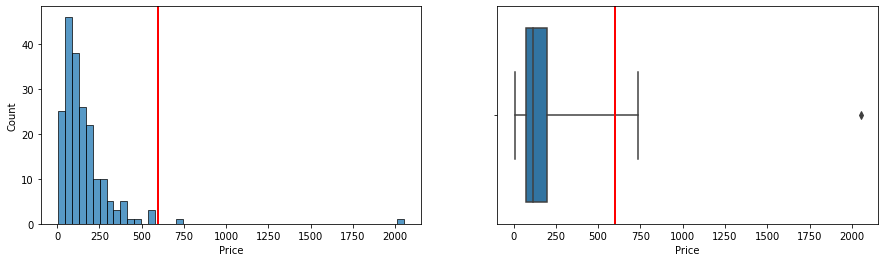

In [52]:
# quick plots to visualize
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.histplot(fundamental_df['Price'], bins=50, ax=ax[0])
sns.boxplot(x='Price', data=fundamental_df, ax=ax[1], whis=5)
# whis=5 means values which are greater than 3rd Quartile + 5 * IQR, default is whis=1.5

# plotting arbitrary line of 600
ax[0].axvline(x=600, ls='-', lw=2, color='r')
ax[1].axvline(x=600, ls='-', lw=2, color='r');

# summary statistics
fundamental_df['Price'].describe()

**Note:** From the charts and summary statistics, we observed that there are outlier companies with prices greater than 2000. Applying an abitrary number of 600 on the plots, it look like a reasonable threshold to split the outliers in the plots considering we have applied whis=5 on the box plot). Majority of the companies prices were less than 250 and there is a right skew in the distribution. Thus, we decided to drop the outliers companies.

In [53]:
# filtering the outliers companies to drop
fundamental_df[['Price', 'ticker', 'name']][fundamental_df['Price']>600]

,Price,ticker,name
27,2051.58,CABO,"Cable One, Inc."
153,736.35,SHW,The Sherwin-Williams Company


In [54]:
# dropping CABO & SHW
fundamental_df.drop(index=fundamental_df[fundamental_df['ticker'] == 'CABO'].index, inplace=True)
fundamental_df.drop(index=fundamental_df[fundamental_df['ticker'] == 'SHW'].index, inplace=True)
fundamental_df.shape

(195, 54)

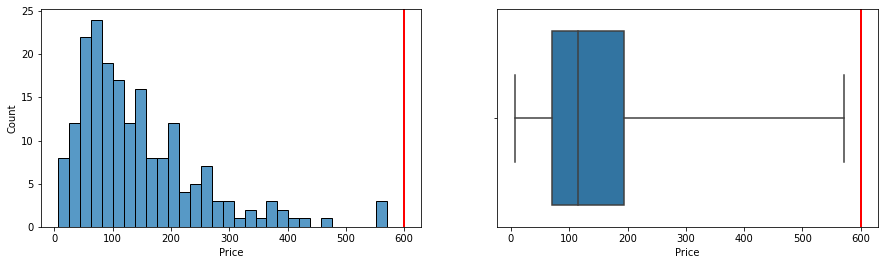

In [55]:
# plots to visualize after dropping outliers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.histplot(fundamental_df['Price'], bins=30, ax=ax[0])
sns.boxplot(x='Price', data=fundamental_df, ax=ax[1], whis=5)
ax[0].axvline(x=600, ls='-', lw=2, color='r')
ax[1].axvline(x=600, ls='-', lw=2, color='r');

**Note:** After dropping the outliers, the plots look more reasonably distributed and no extreme outliers.

#### Market Capitalization, Volume and Price

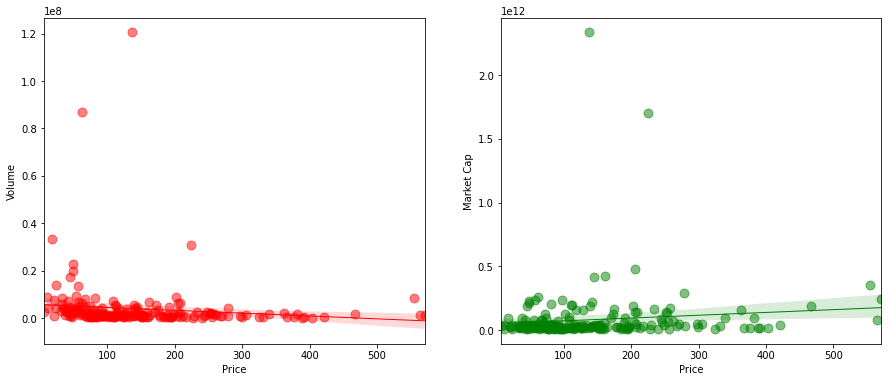

In [58]:
# quick plots to visualize
tmp = fundamental_df[['Market Cap', 'Volume', 'Price']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.regplot(x='Price', y='Volume', data=tmp, ax=ax[0], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})

sns.regplot(x='Price', y='Market Cap', data=tmp, ax=ax[1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1});

**Note:** From the left plot, we can see that majority of companies had volume in the lower range (<200 mil) and this apply to the entire price range of the dataset. The few companies with high volume (>300 mil) had prices lower than $200.

Companies may conduct stock splits over its history that will lower their stock prices but increase number of shares in circulation. Thus, volume determines liquidity of the company shares and is related to companies prices but it does not look like a strong relation here. Moreover, Volume data here is only a snapshot, if we were to use volume data in our models we should be using daily volumes instead of snapshot volumes.

On the right plot, the same can be said about Market Cap but the trend seems to be stronger than Volume.

Thus, we shall drop this snapshot Volume indicator and keep Market Cap. In any case, we will be using the daily volumes in the modeling which will be more useful.

In [59]:
# drop Volume
fundamental_df.drop('Volume', axis=1, inplace=True)

#### Price-to-something features and Price

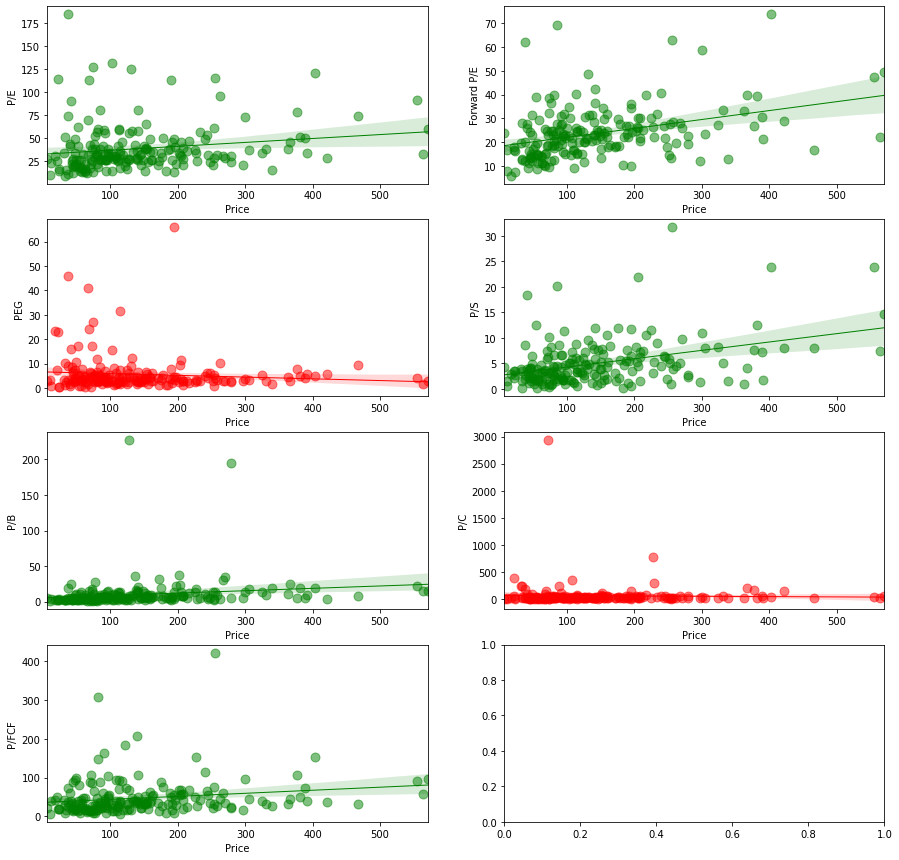

In [60]:
# quick plots to visualize
tmp = fundamental_df[['P/E', 'Forward P/E', 'PEG', 'P/S', 'P/B', 'P/C', 'P/FCF', 'Price']]
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
sns.regplot(x='Price', y='P/E', data=tmp, ax=axs[0,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Forward P/E', data=tmp, ax=axs[0,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='PEG', data=tmp, ax=axs[1,0], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='P/S', data=tmp, ax=axs[1,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='P/B', data=tmp, ax=axs[2,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='P/C', data=tmp, ax=axs[2,1], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='P/FCF', data=tmp, ax=axs[3,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1});

**Note:** Without going too deep into explaining what each of these indicators mean, judging from the plots we can see that there is almost no visible trend for `P/C`. Hence, we shall drop this indicator.

There appears to be a some trend for `P/E` `PEG` `P/B` `P/PCF` `Forward P/E` `P/S`. Hence, we shall keep these indicators.

In [61]:
# drop PEG P/FCF P/C
fundamental_df.drop('P/C', axis=1, inplace=True)

#### EPS features

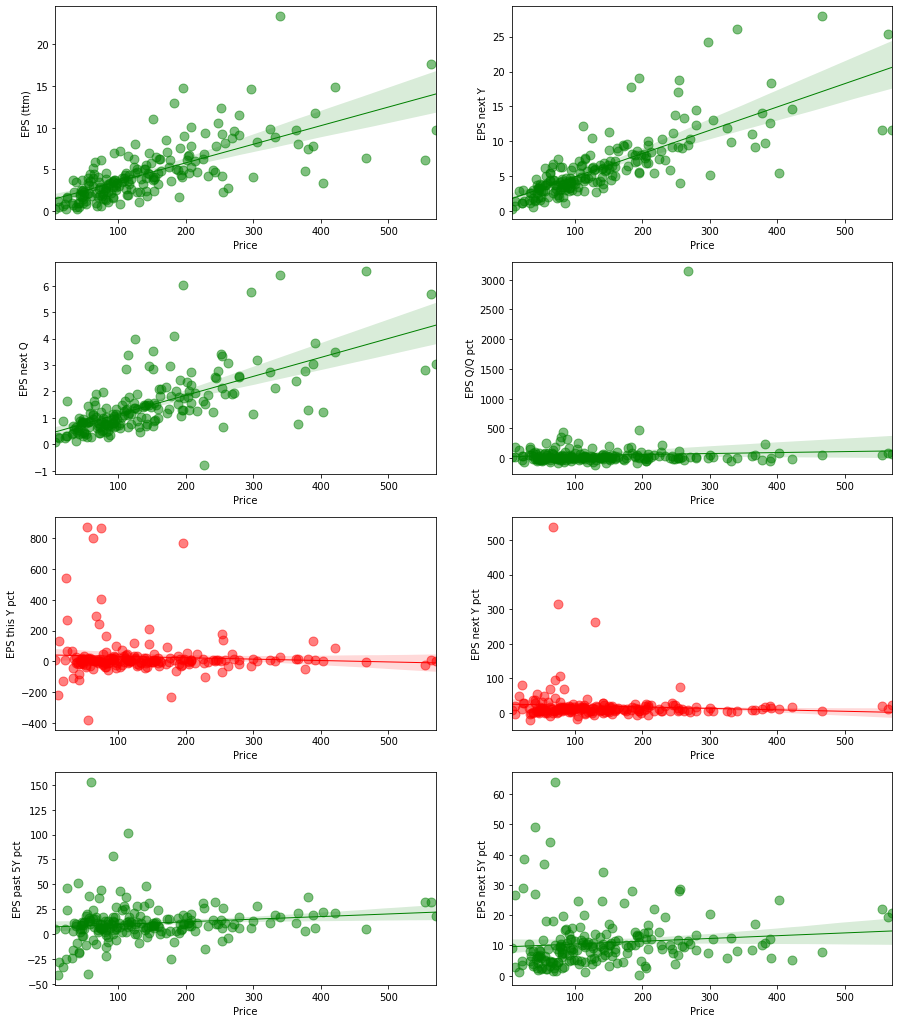

In [63]:
# quick plots to visualize
tmp = fundamental_df[['EPS (ttm)', 'EPS next Y', 'EPS next Q', 'EPS this Y pct', 'EPS next Y pct',
                      'EPS next 5Y pct', 'EPS past 5Y pct', 'EPS Q/Q pct', 'Price']]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))
sns.regplot(x='Price', y='EPS (ttm)', data=tmp, ax=axs[0,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='EPS next Y', data=tmp, ax=axs[0,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='EPS next Q', data=tmp, ax=axs[1,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='EPS Q/Q pct', data=tmp, ax=axs[1,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='EPS this Y pct', data=tmp, ax=axs[2,0], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='EPS next Y pct', data=tmp, ax=axs[2,1], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='EPS past 5Y pct', data=tmp, ax=axs[3,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='EPS next 5Y pct', data=tmp, ax=axs[3,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1});

**Note:** From the plots we can see that for `EPS(ttm)` `EPS next Y` `EPS next Q` have stronger positive relations to `Price` which make sense as these are indicators that reflect the most recent and future projection of earnings per share.

`EPS Q/Q pct` `EPS this Y pct` `EPS next Y pct` are percentage representations of the above 3 indicators so we can drop these to avoid double representation.

`EPS past 5Y pct` `EPS next 5Y pct` although are percentage representations as well, we will keep them because there are no corresponding indicators with values for these.

In [64]:
# drop EPS Q/Q pct, EPS this Y pct, EPS next Y pct
fundamental_df.drop(['EPS Q/Q pct', 'EPS this Y pct', 'EPS next Y pct'], axis=1, inplace=True)

#### Insider, Institutional and Shares features

C:\Users\scbje\anaconda3\envs\stock3\envs\stocktf2.3\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


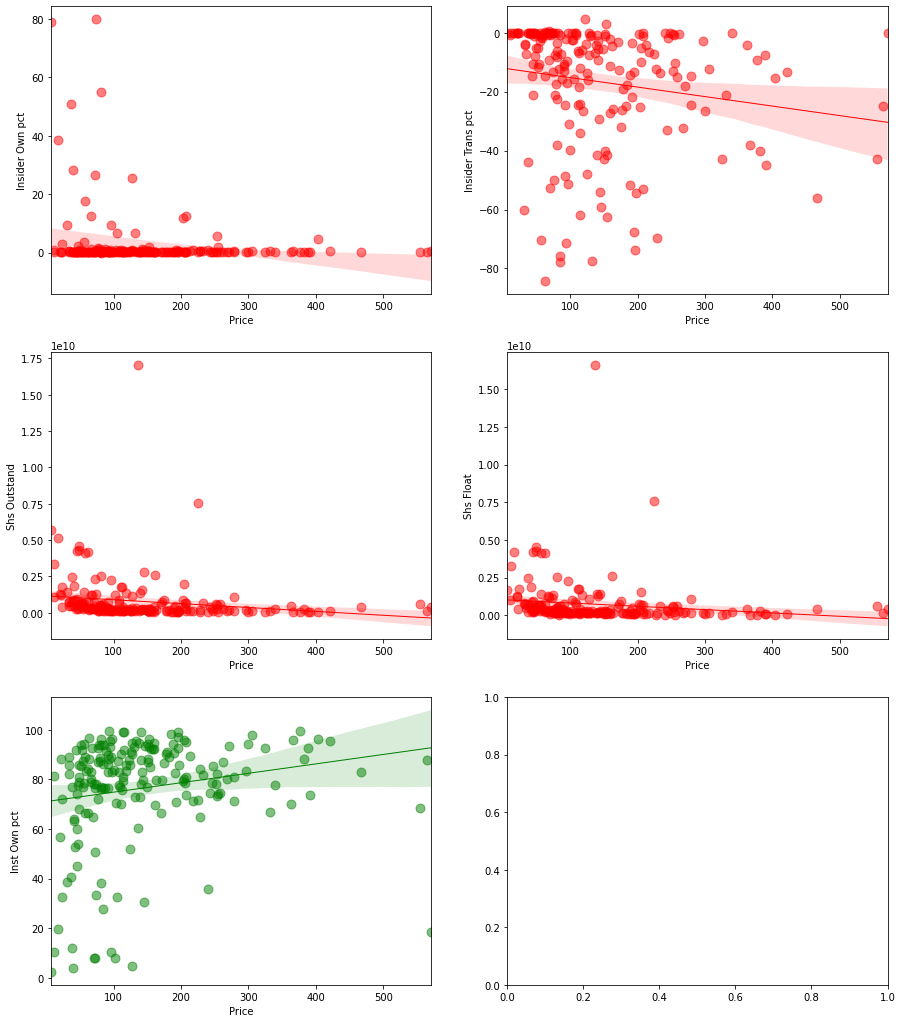

In [69]:
# quick plots to visualize
tmp = fundamental_df[['Insider Own pct', 'Shs Outstand', 'Insider Trans pct', 'Shs Float',
                      'Inst Own pct', 'Price']]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
sns.regplot(x='Price', y='Insider Own pct', data=tmp, ax=axs[0,0], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Insider Trans pct', data=tmp, ax=axs[0,1], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Shs Outstand', data=tmp, ax=axs[1,0], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Shs Float', data=tmp, ax=axs[1,1], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Inst Own pct', data=tmp, ax=axs[2,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1});

**Note:** From the plots, we can see that `Insider Own pct` `Insider Trans pct` have negative relation to `Price`. This means that as `Price` goes higher, the percentage of Insider owning shares of the companies as well as the percentage of transactions reduce. We shall keep these.

`Shs Outstand` refers to the total number of shares a company has issued, while `Shs Float` refers to shares that are publicly owned, unrestricted and available on the open market. Although the plots look almost identical, they have negative relation to `Price`. We shall keep these.

`Inst Own pct` refers to the percentage of share own by Institutional investors. We can see that a majority of the companies have high Institutional ownership and there is a positive relation to `Price`. We shall keep this.

#### Technical Indicators features

C:\Users\scbje\anaconda3\envs\stock3\envs\stocktf2.3\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


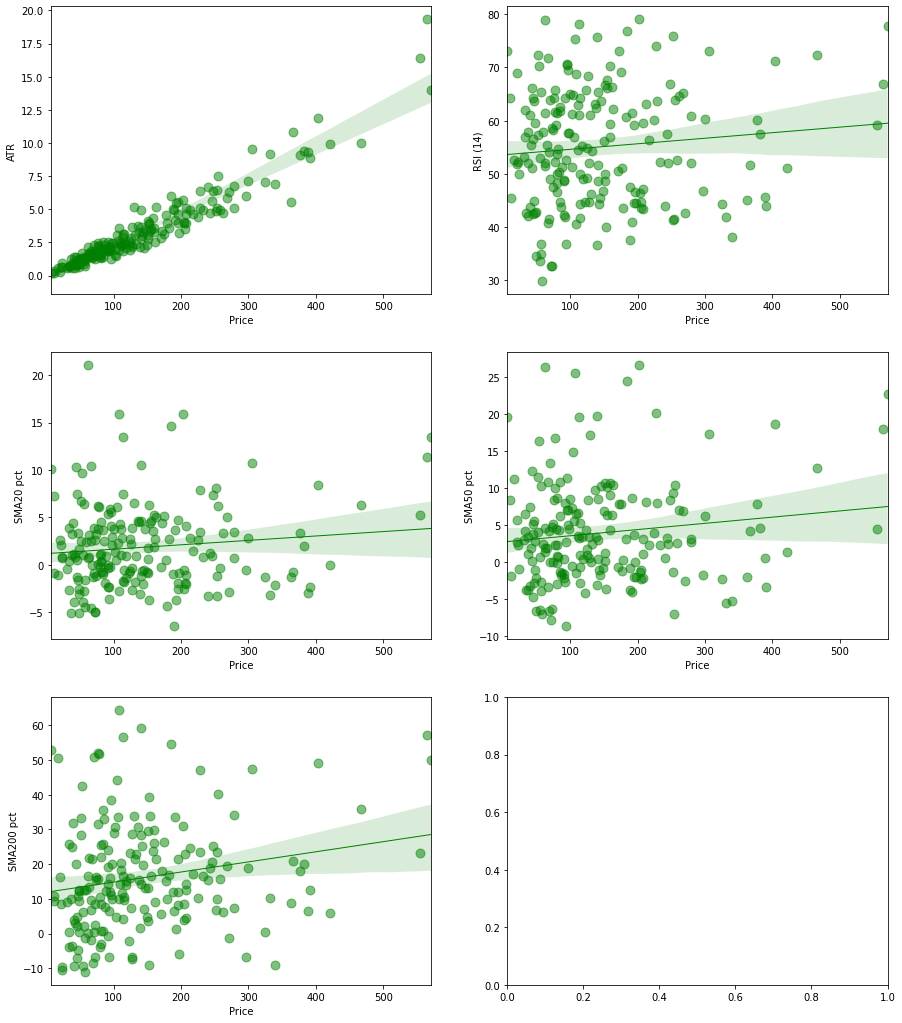

In [71]:
# quick plots to visualize
tmp = fundamental_df[['ATR', 'RSI (14)', 'SMA20 pct','SMA50 pct', 'SMA200 pct', 'Price']]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
sns.regplot(x='Price', y='ATR', data=tmp, ax=axs[0,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='RSI (14)', data=tmp, ax=axs[0,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='SMA20 pct', data=tmp, ax=axs[1,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='SMA50 pct', data=tmp, ax=axs[1,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='SMA200 pct', data=tmp, ax=axs[2,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1});

**Note:** From the plots we can see that all these technical indicator features have clear relation to Price, especially ATR. Hence, we shall keep these.

#### Dividends features

C:\Users\scbje\anaconda3\envs\stock3\envs\stocktf2.3\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


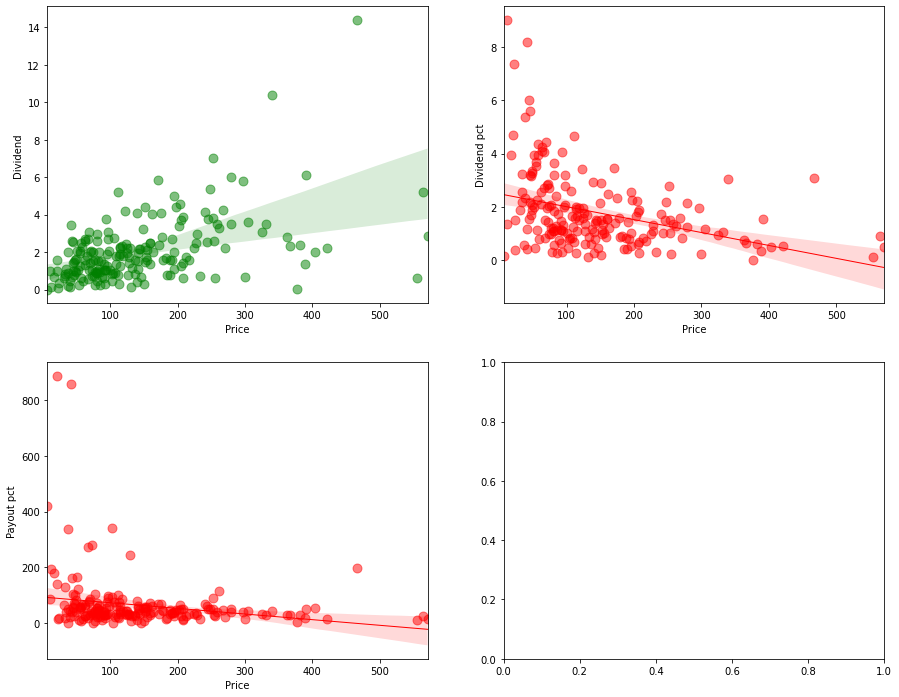

In [73]:
# quick plots to visualize
tmp = fundamental_df[['Dividend', 'Dividend pct', 'Payout pct', 'Price']]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
sns.regplot(x='Price', y='Dividend', data=tmp, ax=axs[0,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Dividend pct', data=tmp, ax=axs[0,1], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Payout pct', data=tmp, ax=axs[1,0], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1});

**Note:** `Dividend` is the value of dividend paid and companies with higher share prices generally pay a higher value dividend as the cost of shares ownership is higher. This explains the positive relation to `Price`. `Dividend pct` demonstrates that when expressed as a percentage. The relationship to `Price` is reversed. We shall keep both indicators as in reality different investors profiles may prefer one over the other.

`Payout pct` has a negative relation to `Price` which is reflective of market where a low payout ratio can signal that a company is re-investing the bulk of its earnings into expanding operations. A payout ratio over 100% indicates that the company is paying out more in dividends than its earning can support, which some view as an unsustainable practice. We shall keep this indicator as the market is made up of companies of both kinds.

#### Profits, Earnings, Debt features

C:\Users\scbje\anaconda3\envs\stock3\envs\stocktf2.3\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


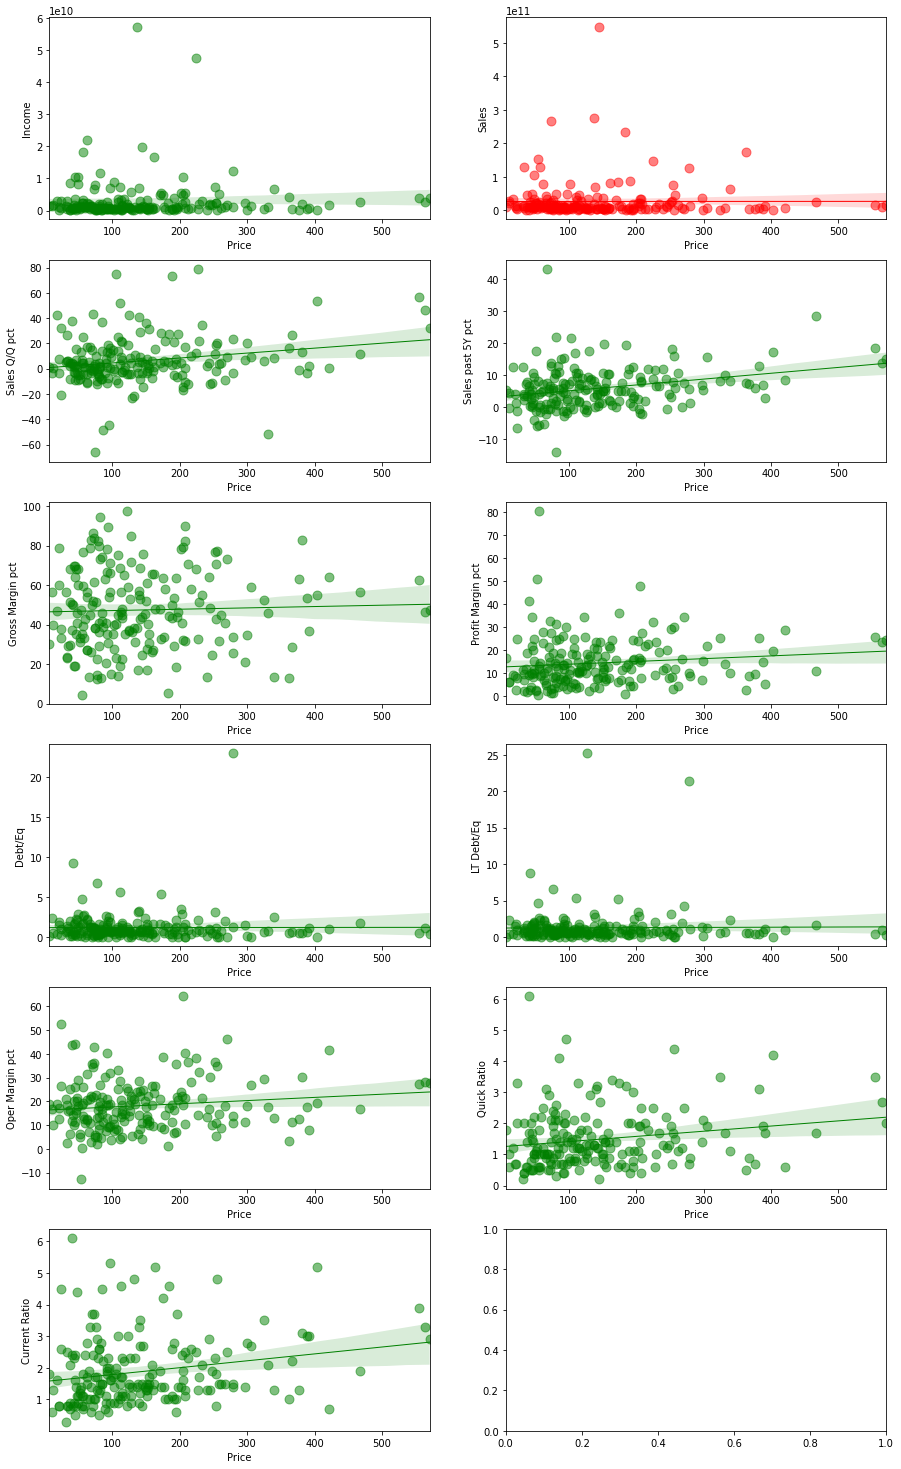

In [76]:
# quick plots to visualize
tmp = fundamental_df[['Income', 'Sales', 'Sales past 5Y pct', 'Gross Margin pct',
                      'Sales Q/Q pct', 'Oper Margin pct', 'Debt/Eq', 'Profit Margin pct',
                      'LT Debt/Eq', 'Quick Ratio', 'Current Ratio', 'Price']]

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15, 26))
sns.regplot(x='Price', y='Income', data=tmp, ax=axs[0,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Sales', data=tmp, ax=axs[0,1], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Sales Q/Q pct', data=tmp, ax=axs[1,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Sales past 5Y pct', data=tmp, ax=axs[1,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Gross Margin pct', data=tmp, ax=axs[2,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Profit Margin pct', data=tmp, ax=axs[2,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Debt/Eq', data=tmp, ax=axs[3,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='LT Debt/Eq', data=tmp, ax=axs[3,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Oper Margin pct', data=tmp, ax=axs[4,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Quick Ratio', data=tmp, ax=axs[4,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Current Ratio', data=tmp, ax=axs[5,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1});

**Note:** Almost all indicators are showing a positive relation to Price so we will keep most of these indicators. We will investigate more into `Debt/Eq` `LT Debt/Eq` as there are clear outliers that may not be representative of the relation and causing a skew. Moreover, as an investor, we tend to pay more attention to high level of debts.

In [77]:
# investigate 'Debt/Eq', 'LT Debt/Eq'
fundamental_df[(fundamental_df['Debt/Eq']>20) | (fundamental_df['LT Debt/Eq']>20)][['ticker', 'name', 'Debt/Eq', 'LT Debt/Eq']]

,ticker,name,Debt/Eq,LT Debt/Eq
46,CTXS,"Citrix Systems, Inc.",0.00,25.18
80,HD,"The Home Depot, Inc.",23.01,21.39


**Note:** Investigating further revealed that only two companies (CTXS and HD) sit as outliers. This is the truth in the market where some companies incurred high long term debts to fund expansion, R&D or acquisitions. A quick check into what these companies do on their website did suggest the possibility of incurring debt for good cause. Investors have a choice to invest in these companies or not. Thus, we shall keep these indicators.

#### Other Ratio features

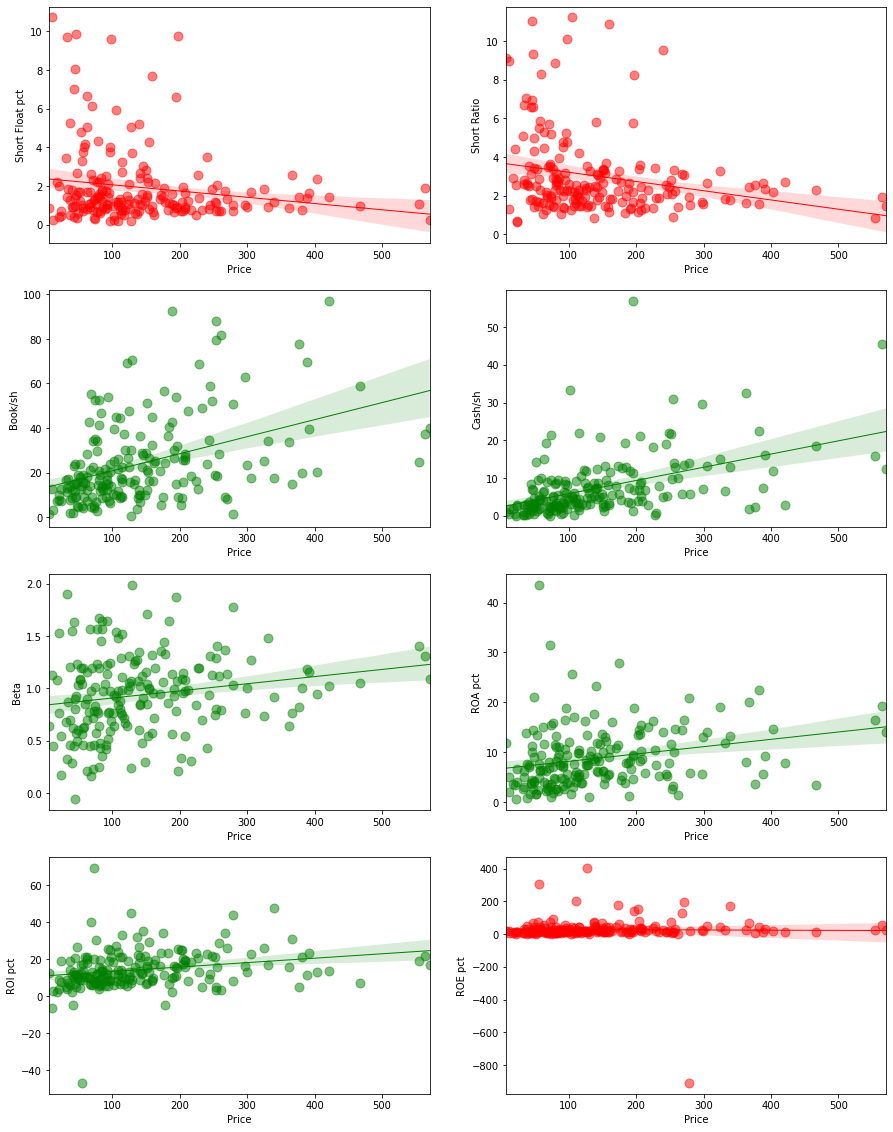

In [80]:
# quick plots to visualize
tmp = fundamental_df[['Short Float pct', 'Short Ratio', 'Book/sh', 'Cash/sh',
                      'ROA pct', 'ROE pct', 'ROI pct', 'Beta', 'Price']]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
sns.regplot(x='Price', y='Short Float pct', data=tmp, ax=axs[0,0], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Short Ratio', data=tmp, ax=axs[0,1], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Book/sh', data=tmp, ax=axs[1,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Cash/sh', data=tmp, ax=axs[1,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='Beta', data=tmp, ax=axs[2,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='ROA pct', data=tmp, ax=axs[2,1], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='ROI pct', data=tmp, ax=axs[3,0], color='green',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1})
sns.regplot(x='Price', y='ROE pct', data=tmp, ax=axs[3,1], color='red',
            scatter_kws={'alpha':0.5, 's':80}, line_kws={'lw':1});

**Note:** Most of the above indicators have positive/negative relation to Price. Although `ROI pct` `ROE pct` have negative percentage values that look like outliers. These are actually representative of the real market which indicate that these companies are not profitable for the period of this data set. Thus, we shall keep all these features.

#### Sector and Industry

Number of Sectors covered : 11


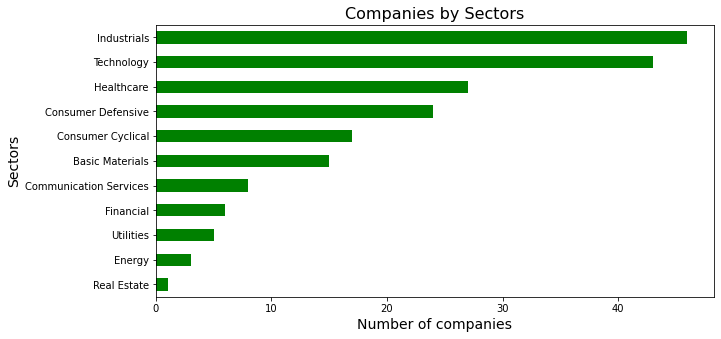

In [81]:
# plot by sectors
fig = plt.figure(figsize=(10,5))
print('Number of Sectors covered :', fundamental_df.sector.nunique())
fundamental_df.sector.value_counts().sort_values().plot.barh(color='green')
plt.title('Companies by Sectors', fontsize=16)
plt.xlabel('Number of companies', fontsize=14)
plt.ylabel('Sectors', fontsize=14);

**Note:** There are 11 sectors in this dataset with more companies in the Industrials and Technology sectors. A truly diversified portfolio should have exposure to every sector but in reality it is usually tough to do so. From experience, a 65-80% sector coverage can be consider as a relatively sound portfolio. i.e. 7-9 sectors in our context here

Number of Industries covered : 70


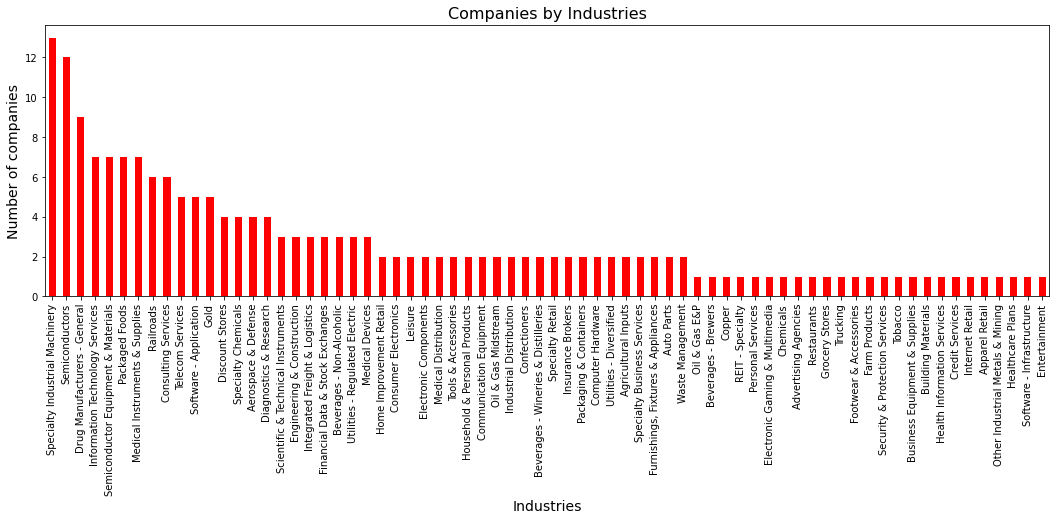

In [82]:
# plot by Industries
fig = plt.figure(figsize=(18,5))
print('Number of Industries covered :', fundamental_df.industry.nunique())
fundamental_df.industry.value_counts().sort_values(ascending=False).plot.bar(color='red')
plt.title('Companies by Industries', fontsize=16)
plt.xlabel('Industries', fontsize=14)
plt.ylabel('Number of companies', fontsize=14);

**Note:** There are 70 Industries within the 11 sectors and it will not be realistic to diversify a portfolio to cover all industries. Thus, we shall focus on building a portfolio with sector coverage between 65-80% with about 10 companies.

#### Correlation of features and Price

We started the EDA with 71 indicators (excluding `Price` `ticker` `name` `sector` `industry`) and 842 companies. After the EDA process we filtered down to 44 indicators and 195 companies. The coverage consists of 11 Sectors and 70 Industries. Now we shall analyst numerically the relation of these indicators against `Price`.

Firstly, we want to establish which indicators have very high/very low correlation to the target variable 'Price'. Either extremes would not be helpful as a criteria for selecting companies as viable investment choices. As we are not going to predict prices for few hundreds companies, we need a systematic way to select companies using features that are of high importance.

In [83]:
print(fundamental_df.shape)
fundamental_df.columns

(195, 49)


Index(['P/E', 'EPS (ttm)', 'Insider Own pct', 'Shs Outstand', 'Market Cap',
       'Forward P/E', 'EPS next Y', 'Insider Trans pct', 'Shs Float', 'Income',
       'PEG', 'EPS next Q', 'Inst Own pct', 'Short Float pct', 'Sales', 'P/S',
       'Short Ratio', 'Book/sh', 'P/B', 'ROA pct', 'Cash/sh',
       'EPS next 5Y pct', 'ROE pct', 'Dividend', 'P/FCF', 'EPS past 5Y pct',
       'ROI pct', 'Beta', 'Dividend pct', 'Quick Ratio', 'Sales past 5Y pct',
       'Gross Margin pct', 'ATR', 'Current Ratio', 'Sales Q/Q pct',
       'Oper Margin pct', 'RSI (14)', 'Debt/Eq', 'Profit Margin pct',
       'LT Debt/Eq', 'Payout pct', 'Price', 'SMA20 pct', 'SMA50 pct',
       'SMA200 pct', 'ticker', 'name', 'sector', 'industry'],
      dtype='object')

In [84]:
#Correlation with dependent variable, finding those extreme high/low
fundamental_df_corr = fundamental_df.corr()
cor_target = abs(fundamental_df_corr['Price'])
cor_target.sort_values(ascending=False)

Price                1.000000
ATR                  0.955159
EPS next Y           0.769053
EPS (ttm)            0.695844
EPS next Q           0.666772
Dividend             0.485340
Cash/sh              0.478854
Book/sh              0.428863
P/S                  0.390493
Forward P/E          0.371966
Dividend pct         0.364844
Sales past 5Y pct    0.300759
ROA pct              0.258194
Short Ratio          0.246823
ROI pct              0.241036
Sales Q/Q pct        0.221487
Current Ratio        0.214357
Payout pct           0.214069
SMA200 pct           0.197235
Quick Ratio          0.191886
Beta                 0.190794
Inst Own pct         0.184186
P/FCF                0.179382
Shs Outstand         0.178101
Short Float pct      0.176957
P/E                  0.175745
Insider Own pct      0.172741
Insider Trans pct    0.166200
P/B                  0.163807
Shs Float            0.155819
EPS past 5Y pct      0.143959
Oper Margin pct      0.134007
SMA50 pct            0.130938
Profit Mar

**Note:** From the above coefficients we would want to exclude indicators that have very high relation to Price as these will likely skew the result. For now, we decided to omit those that are above 0.8. On the other hand, we also want to omit indicators that have very low relation to Price as they will not be helpful in making an accurate prediction. We decided to omit those that are below 0.2. Essentially, we are omitting the top 20% and bottom 20%. We may re-visit this decision if necessary.

In [85]:
# excluding highly correlated indicators (top 20%) but include Price for heatmap comparison
ex_high_features = cor_target[(cor_target<0.8) | (cor_target==1)]

# excluding lowly correlated indicators (bottom 20%) to avoid dropping too many indicators
relevant_features = ex_high_features[ex_high_features>0.20]

# generate a list of relevant indicators
print(len(relevant_features.sort_values(ascending=False)))
temp_list = relevant_features.sort_values(ascending=False).index.tolist()
print(temp_list)

# create a temp df for heatmap plotting
temp_df = fundamental_df[temp_list]

17
['Price', 'EPS next Y', 'EPS (ttm)', 'EPS next Q', 'Dividend', 'Cash/sh', 'Book/sh', 'P/S', 'Forward P/E', 'Dividend pct', 'Sales past 5Y pct', 'ROA pct', 'Short Ratio', 'ROI pct', 'Sales Q/Q pct', 'Current Ratio', 'Payout pct']


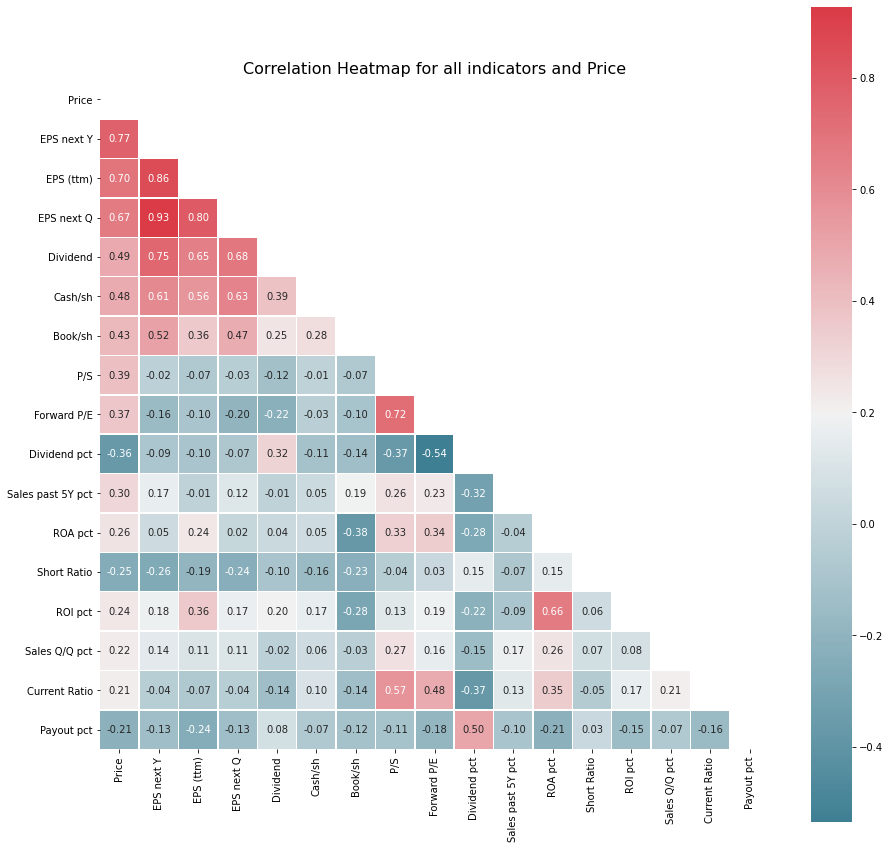

In [86]:
# plotting a heatmap to visualize correlations between indicators and price
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(15,15))
temp_df_corr = temp_df.corr()

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(temp_df_corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(temp_df_corr, mask=mask, square=True, annot=True, cmap=cmap,
            fmt=".2f", linewidths=.5, annot_kws={'fontsize' : 10});
plt.title("Correlation Heatmap for all indicators and Price", fontsize=16)
plt.show()

**Note:** After setting the correlation boundaries of top 20% and bottom 20%, we are left with 16 indicators excluding `Price`.

We also see that there are indicators with high collinearity (>0.8) with each other and only one of these pairs should remain because they will have almost the same effect on the target variable `Price`. They are:

    - `EPS (ttm)` vs `EPS next Y` - 0.86 (dropping `EPS (ttm)` as it had lower correlation with `Price`)
    - `EPS next Q` vs `EPS next Y` - 0.93 (dropping `EPS next Q` as it had lower correlation with `Price`)

Let's tidy the list then re-plot the heatmap to visualize the collinearity better.

In [122]:
# tidy the list and remove Price
temp2_df = temp_df.drop(['EPS (ttm)', 'EPS next Q', 'Price'], axis=1, inplace=False)
temp2_df_corr = temp2_df.corr()

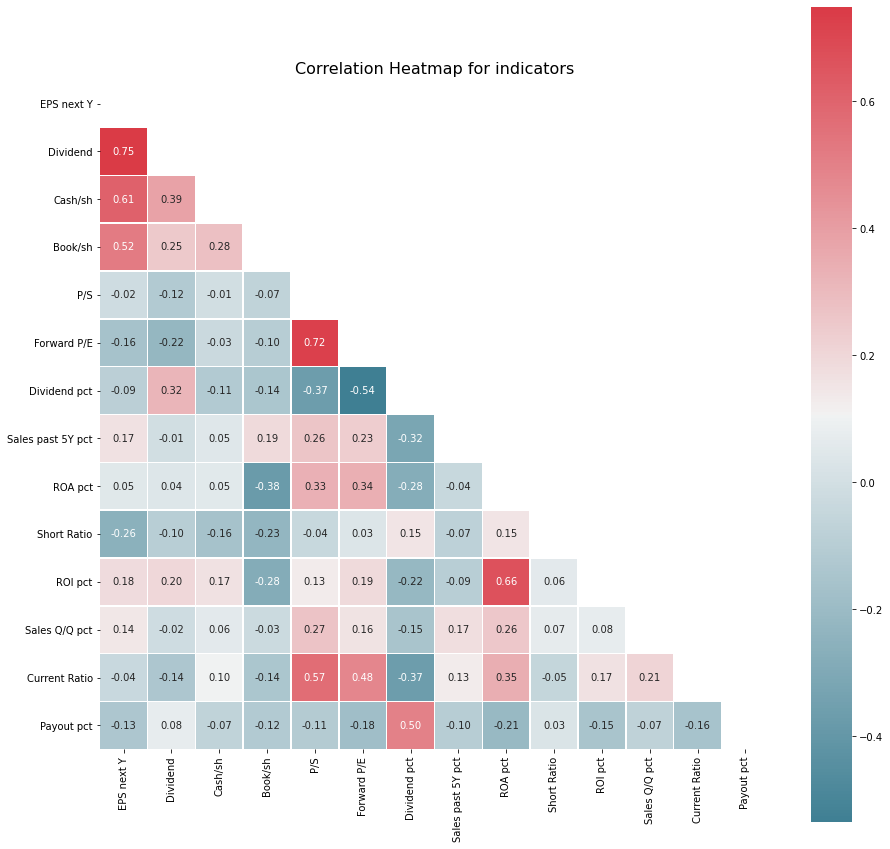

In [123]:
# plotting a heatmap to visualize correlations between indicators i.e. collinearity

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(15,15))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(temp2_df_corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(temp2_df_corr, mask=mask, square=True, annot=True, cmap=cmap,
            fmt=".2f", linewidths=.5, annot_kws={'fontsize' : 10});
plt.title("Correlation Heatmap for indicators", fontsize=16)
plt.show()

**Note:** Now the heatmap look more manageable within the coefficient limits that we decided to omit. However, there are still several indicators with high collinearity. The potential to drop indicators are:

- `EPS next Y` `Dividend` `Forward P/E` `P/S`

We may have to re-visit this decision if necessary. Next we update the final indicators list.

In [124]:
# update final indicators shortlist with other identification columns
train_list = temp2_df.columns.tolist()
id_list = ['ticker', 'name', 'sector', 'industry', 'Price']
for i in id_list:
    train_list.append(i)
print(len(train_list))
print(train_list)

19
['EPS next Y', 'Dividend', 'Cash/sh', 'Book/sh', 'P/S', 'Forward P/E', 'Dividend pct', 'Sales past 5Y pct', 'ROA pct', 'Short Ratio', 'ROI pct', 'Sales Q/Q pct', 'Current Ratio', 'Payout pct', 'ticker', 'name', 'sector', 'industry', 'Price']


## PART 2 PORTFOLIO BUILDING

Even after filtering using correlation method there are still about 200 companies in the data set. It will be very hard to monitor and trade so many company in a portfolio. Thus, we need to find a way to determine what is the best selection of companies that would offer the best diversification across different market sectors. 

We shall first rely on domain knowledge of these indicators to build a Human portfolio. Thereafter, we shall explore using unsupervised learning methods like DBSCAN and Kmeans to find a solution. Afterall, machine learning techniques will be able to process more information than human.

### Human Portfolio

Now we shall apply domain knowledge on some of the remaining indicators to shortlist companies for our portfolio. This is base on personal investment strategies. We will try to briefly explain the rationale of our choices and we aim to narrow down to 7-9 sectors with about 10 companies as explained in earlier sections about sectors coverage. We will not go through every indicator but only those that stands out intuitively from an investor perspective.

In [125]:
# domain knowledge portfolio preliminary selections
domain_df = fundamental_df[train_list]
print(domain_df.shape)
domain_df.head()

(195, 19)


,EPS next Y,Dividend,Cash/sh,Book/sh,P/S,Forward P/E,Dividend pct,Sales past 5Y pct,ROA pct,Short Ratio,ROI pct,Sales Q/Q pct,Current Ratio,Payout pct,ticker,name,sector,industry,Price
0,4.17,0.78,4.70,15.77,7.29,30.44,0.61,5.7,7.5,1.42,10.0,8.5,2.3,30.3,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,127.00
1,4.37,0.82,5.33,3.83,8.50,31.33,0.60,3.3,17.6,0.84,31.7,1.0,1.4,24.1,AAPL,Apple Inc.,Technology,Consumer Electronics,136.87
2,12.19,5.20,4.46,8.63,4.88,9.13,4.67,10.8,6.1,1.62,21.2,52.2,1.0,100.6,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,111.26
3,4.37,1.80,2.70,17.69,6.14,25.82,1.59,9.5,5.0,2.04,8.2,9.6,1.7,73.3,ABT,Abbott Laboratories,Healthcare,Medical Devices,112.95
4,9.07,3.52,13.06,28.23,3.83,28.44,1.36,6.1,14.6,2.26,28.9,3.5,1.5,39.7,ACN,Accenture plc,Technology,Information Technology Services,257.94


In [126]:
domain_df['Dividend pct'].describe()

count    195.000000
mean       1.794615
std        1.415433
min        0.020000
25%        0.855000
50%        1.490000
75%        2.245000
max        9.020000
Name: Dividend pct, dtype: float64

In [127]:
# paying at least 3% dividends
domain_df = domain_df[domain_df['Dividend pct']>3]
domain_df.shape

(31, 19)

In [128]:
domain_df['Forward P/E'].describe()

count    31.000000
mean     13.607097
std       3.539818
min       6.050000
25%      11.460000
50%      13.610000
75%      15.610000
max      23.250000
Name: Forward P/E, dtype: float64

In [129]:
# forward price-to-earnings lesser than 15 times (lower better)
domain_df = domain_df[domain_df['Forward P/E']<15]
domain_df.shape

(19, 19)

In [130]:
domain_df['Sales past 5Y pct'].describe()

count    19.000000
mean      3.068421
std       4.787954
min      -5.200000
25%      -0.250000
50%       2.100000
75%       6.700000
max      12.500000
Name: Sales past 5Y pct, dtype: float64

In [131]:
# sales past 5 years must be positive
domain_df = domain_df[domain_df['Sales past 5Y pct']>0]
domain_df.shape

(13, 19)

In [132]:
domain_df['ROA pct'].describe()

count    13.000000
mean      6.215385
std       4.058499
min       1.500000
25%       3.600000
50%       5.000000
75%       7.700000
max      13.300000
Name: ROA pct, dtype: float64

In [133]:
domain_df['ROI pct'].describe()

count    13.000000
mean      7.969231
std      21.545741
min     -47.100000
25%       2.100000
50%       9.700000
75%      19.200000
max      47.700000
Name: ROI pct, dtype: float64

In [134]:
# ROA pct and ROI pct at least 2% (higher mean better use of assets at disposal and better invesment decisions)
domain_df = domain_df[(domain_df['ROA pct']>2) & (domain_df['ROI pct']>2)]
domain_df.shape

(10, 19)

In [135]:
# preview the list of 10 companies filtered for the portfolio
domain_df

,EPS next Y,Dividend,Cash/sh,Book/sh,P/S,Forward P/E,Dividend pct,Sales past 5Y pct,ROA pct,Short Ratio,ROI pct,Sales Q/Q pct,Current Ratio,Payout pct,ticker,name,sector,industry,Price
2,12.19,5.20,4.46,8.63,4.88,9.13,4.67,10.8,6.1,1.62,21.2,52.2,1.0,100.6,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,111.26
28,2.61,1.10,0.14,17.16,1.45,13.05,3.23,4.1,5.0,2.78,7.2,6.2,0.8,37.3,CAG,"Conagra Brands, Inc.",Consumer Defensive,Packaged Foods,34.06
42,3.37,1.44,7.15,9.02,3.94,13.38,3.19,0.1,11.3,1.81,20.7,-9.3,1.6,57.4,CSCO,"Cisco Systems, Inc.",Technology,Communication Equipment,45.11
77,3.08,2.03,2.41,7.85,2.00,12.27,5.37,8.0,7.7,2.63,14.3,-7.9,0.9,0.0,GSK,GlaxoSmithKline plc,Healthcare,Drug Manufacturers - General,37.78
104,26.15,10.40,12.81,17.73,1.48,12.99,3.06,8.4,13.3,1.79,47.7,8.7,1.3,41.2,LMT,Lockheed Martin Corporation,Industrials,Aerospace & Defense,339.67
121,6.39,2.60,2.95,11.54,4.27,12.70,3.20,2.1,13.2,1.79,19.2,1.2,1.3,53.7,MRK,"Merck & Co., Inc.",Healthcare,Drug Manufacturers - General,81.18
145,3.95,1.57,3.49,15.73,2.18,12.18,3.27,3.2,4.2,3.43,9.7,-2.4,1.1,99.2,RCI,Rogers Communications Inc.,Communication Services,Telecom Services,48.04
170,3.33,2.54,1.26,23.76,4.14,13.61,5.61,5.4,4.3,6.95,6.6,2.0,0.5,104.9,TRP,TC Energy Corporation,Energy,Oil & Gas Midstream,45.29
180,2.89,0.69,1.73,7.30,3.00,6.05,3.95,12.5,3.6,2.90,2.1,42.4,1.6,180.5,VALE,Vale S.A.,Basic Materials,Other Industrial Metals & Mining,17.47
183,5.00,2.51,2.18,15.72,1.84,11.46,4.38,0.7,6.2,2.29,13.7,-4.1,1.1,55.6,VZ,Verizon Communications Inc.,Communication Services,Telecom Services,57.27


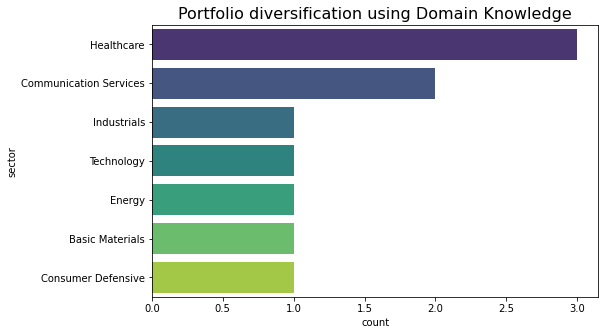

In [136]:
# visualizing diversification by manual selection 
plt.figure(figsize=(8,5))
order = domain_df['sector'].value_counts().index.tolist()
sns.countplot(y='sector', data=domain_df, orient='h', palette='viridis', order=order)
plt.title('Portfolio diversification using Domain Knowledge', fontsize=16);

**Note:** As shown in the plot above, we are able to filter down the list of companies using domain knowledge and still achieving the desired sector coverage of 7-9 sectors. Moreover, the number of companies in this portfolio is only 10 which is manageable in real life.

In [137]:
# export domain knowledge portfolio
#domain_df.to_csv('datasets/domain_portfolio.csv', index=False)
domain_df

,EPS next Y,Dividend,Cash/sh,Book/sh,P/S,Forward P/E,Dividend pct,Sales past 5Y pct,ROA pct,Short Ratio,ROI pct,Sales Q/Q pct,Current Ratio,Payout pct,ticker,name,sector,industry,Price
2,12.19,5.20,4.46,8.63,4.88,9.13,4.67,10.8,6.1,1.62,21.2,52.2,1.0,100.6,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,111.26
28,2.61,1.10,0.14,17.16,1.45,13.05,3.23,4.1,5.0,2.78,7.2,6.2,0.8,37.3,CAG,"Conagra Brands, Inc.",Consumer Defensive,Packaged Foods,34.06
42,3.37,1.44,7.15,9.02,3.94,13.38,3.19,0.1,11.3,1.81,20.7,-9.3,1.6,57.4,CSCO,"Cisco Systems, Inc.",Technology,Communication Equipment,45.11
77,3.08,2.03,2.41,7.85,2.00,12.27,5.37,8.0,7.7,2.63,14.3,-7.9,0.9,0.0,GSK,GlaxoSmithKline plc,Healthcare,Drug Manufacturers - General,37.78
104,26.15,10.40,12.81,17.73,1.48,12.99,3.06,8.4,13.3,1.79,47.7,8.7,1.3,41.2,LMT,Lockheed Martin Corporation,Industrials,Aerospace & Defense,339.67
121,6.39,2.60,2.95,11.54,4.27,12.70,3.20,2.1,13.2,1.79,19.2,1.2,1.3,53.7,MRK,"Merck & Co., Inc.",Healthcare,Drug Manufacturers - General,81.18
145,3.95,1.57,3.49,15.73,2.18,12.18,3.27,3.2,4.2,3.43,9.7,-2.4,1.1,99.2,RCI,Rogers Communications Inc.,Communication Services,Telecom Services,48.04
170,3.33,2.54,1.26,23.76,4.14,13.61,5.61,5.4,4.3,6.95,6.6,2.0,0.5,104.9,TRP,TC Energy Corporation,Energy,Oil & Gas Midstream,45.29
180,2.89,0.69,1.73,7.30,3.00,6.05,3.95,12.5,3.6,2.90,2.1,42.4,1.6,180.5,VALE,Vale S.A.,Basic Materials,Other Industrial Metals & Mining,17.47
183,5.00,2.51,2.18,15.72,1.84,11.46,4.38,0.7,6.2,2.29,13.7,-4.1,1.1,55.6,VZ,Verizon Communications Inc.,Communication Services,Telecom Services,57.27


In [138]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#domain_df.to_csv('datasets/backups/domain_portfolio.csv', index=False)

In [10]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
#domain_df = pd.read_csv('datasets/backups/domain_portfolio.csv')

### AI Portfolio (Unsupervised Learning DBSCAN)

Now we shall try to build a portfolio using DBSCAN. Recall that our target is 7-9 sectors with about 10 companies.

In [179]:
# DBSCAN portfolio preliminary selections
dbscan_df = fundamental_df[train_list]
print(dbscan_df.shape)
dbscan_df.head()

(195, 19)


,EPS next Y,Dividend,Cash/sh,Book/sh,P/S,Forward P/E,Dividend pct,Sales past 5Y pct,ROA pct,Short Ratio,ROI pct,Sales Q/Q pct,Current Ratio,Payout pct,ticker,name,sector,industry,Price
0,4.17,0.78,4.70,15.77,7.29,30.44,0.61,5.7,7.5,1.42,10.0,8.5,2.3,30.3,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,127.00
1,4.37,0.82,5.33,3.83,8.50,31.33,0.60,3.3,17.6,0.84,31.7,1.0,1.4,24.1,AAPL,Apple Inc.,Technology,Consumer Electronics,136.87
2,12.19,5.20,4.46,8.63,4.88,9.13,4.67,10.8,6.1,1.62,21.2,52.2,1.0,100.6,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,111.26
3,4.37,1.80,2.70,17.69,6.14,25.82,1.59,9.5,5.0,2.04,8.2,9.6,1.7,73.3,ABT,Abbott Laboratories,Healthcare,Medical Devices,112.95
4,9.07,3.52,13.06,28.23,3.83,28.44,1.36,6.1,14.6,2.26,28.9,3.5,1.5,39.7,ACN,Accenture plc,Technology,Information Technology Services,257.94


In [180]:
# setting X
X = dbscan_df.drop(['ticker', 'name', 'sector', 'industry', 'Price'], axis=1, inplace=False)
print(X.shape)

# standard scaling for clustering methods
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

(195, 14)


In [181]:
# define DBSCAN function
def db_optimizer(e, n):
    num_sector = []
    # instantiate and fit
    db = DBSCAN(eps=e, min_samples=n) # between eps 2 to 10 only produce 2 classes
    db.fit(X_scaled)
    
    # no of classes depend on dbscan result
    #print(set(db.labels_))
    
    # attach predicted cluster to original
    dbscan_df.loc[:,'db_cluster'] = db.labels_
    
    # print silhouette score
    #print(silhouette_score(X_scaled, db.labels_))
    
    # find max no of sectors in the cluster
    num_sector = dbscan_df.groupby('db_cluster')['sector'].nunique().max()
    
    # find number of companies in the cluster with max. sector coverage
    cluster = dbscan_df.groupby('db_cluster')['sector'].nunique().sort_values(ascending=False).index[0]
    num_comp = dbscan_df[dbscan_df['db_cluster']==cluster]['ticker'].nunique()
    
    return num_sector, num_comp, cluster

In [201]:
# searching for params that give max. diversification of sectors
# setting variables
best_e = []
best_n = []
best_sec_list = []
best_comp_list = []
best_cluster = []
dbscan_df['db_cluster'] = np.nan

# target is 7-9 sectors with about 10 companies
# note: tried different e and n values range, lowered to 65% sector coverage with 10 companies still no result
# but can run to see the alternatives summary for adjustment in criteria
# below is running with one permutation of values but DBSCAN is not suitable for this

# lowered criteria to 65% sector coverage with 10 companies
target = round(dbscan_df.sector.nunique() * 0.65)
target_num_comp = 10
print(f'Searching (k) for min coverage of {target} sectors with the least number of companies <= {target_num_comp}...')

# start search
for e in np.arange(0.1, 10, 0.1):
    for n in range(10, 15, 1):
        num_sector, num_comp, cluster = db_optimizer(e, n)
        best_e.append(e)
        best_n.append(n)
        best_sec_list.append(num_sector)
        best_comp_list.append(num_comp)
        best_cluster.append(cluster)

        if num_sector != target:
            #print(f'Min coverage for {target} sectors with <= {target_num_comp} companies not achievable with k = {k}')
            pass
        elif num_sector >= target and num_comp <= target_num_comp:
            print('\n=====FOUND best e, n=====')
            print(f'Target sectors to cover = {target}')
            print(f'DBSCAN achieved with e  = {e}')
            print(f'DBSCAN achieved with n  = {n}')
            print(f'Covering max. sectors   = {num_sector}')
            print(f'Num of companies        = {num_comp}')
            print(f'Cluster name            = {cluster}')
            print('========================= (wait...)\n')
    
if best_e != '':
    # print summary of search
    print('\n======ALTERNATIVES SUMMARY======')
    print(f'Best achievable is e     = {best_e}\n')
    print(f'Best achievable is n     = {best_n}\n')
    print(f'Sectors coverage         = {best_sec_list}\n')
    print(f'Num of companies         = {best_comp_list}\n')
    print(f'Clusters                 = {best_cluster}\n')
    print('================================== (END)\n')

Searching (k) for max coverage of 7 sectors with the least number of companies <= 10...

======ALTERNATIVES SUMMARY======
Best achievable is e     = [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2000000000000002, 1.2000000000000002, 1.2000000000000002, 1.2000000000000002, 1.2000000000000002, 1.3000000000000003, 1.3000000000000003, 1.3000000000000003, 1.3000000000000003, 1.3000000000000003, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.5000000000000002, 1.5000000000000002, 1.5000000000000002, 1.5000000000000002, 1.5000000000000002, 1.6, 1.6, 1.6, 1.6, 

**Note:** Even searching over a range of values for epsilon and min_samples going from very low to very high values ranges. DBSCAN was not able to produce clusters that cover desired sectors coverage or number of companies. DBSCAN at best returns two clusters, a -1 class with few companies and another cluster class 0 with the majority companies. This is an indication that DBSCAN is not a suitable clustering method for this set of data.

### AI Portfolio (Unsupervised Learning Kmeans)

Now we shall try to build a portfolio using Kmeans. Recall that our target is 7-9 sectors with about 10 companies.

In [202]:
# Kmeans portfolio preliminary selections
kmeans_df = fundamental_df[train_list]
print(kmeans_df.shape)
kmeans_df.head()

(195, 19)


,EPS next Y,Dividend,Cash/sh,Book/sh,P/S,Forward P/E,Dividend pct,Sales past 5Y pct,ROA pct,Short Ratio,ROI pct,Sales Q/Q pct,Current Ratio,Payout pct,ticker,name,sector,industry,Price
0,4.17,0.78,4.70,15.77,7.29,30.44,0.61,5.7,7.5,1.42,10.0,8.5,2.3,30.3,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,127.00
1,4.37,0.82,5.33,3.83,8.50,31.33,0.60,3.3,17.6,0.84,31.7,1.0,1.4,24.1,AAPL,Apple Inc.,Technology,Consumer Electronics,136.87
2,12.19,5.20,4.46,8.63,4.88,9.13,4.67,10.8,6.1,1.62,21.2,52.2,1.0,100.6,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,111.26
3,4.37,1.80,2.70,17.69,6.14,25.82,1.59,9.5,5.0,2.04,8.2,9.6,1.7,73.3,ABT,Abbott Laboratories,Healthcare,Medical Devices,112.95
4,9.07,3.52,13.06,28.23,3.83,28.44,1.36,6.1,14.6,2.26,28.9,3.5,1.5,39.7,ACN,Accenture plc,Technology,Information Technology Services,257.94


In [203]:
# define kmeans function
def k_optimizer(k):
    num_sector = []
    # instantiate and fit
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    km.fit(X_scaled)
    
    # class attribute no of class according to what was set
    #print(set(km.labels_))
    
    # attach predicted cluster to original
    kmeans_df.loc[:,'kmeans_cluster'] = km.labels_
    
    # print silhouette score
    #print(silhouette_score(X_scaled, km.labels_))
    
    # find max no of sectors in the cluster
    num_sector = kmeans_df.groupby('kmeans_cluster')['sector'].nunique().max()
    
    # find number of companies in the cluster with max. sector coverage
    cluster = kmeans_df.groupby('kmeans_cluster')['sector'].nunique().sort_values(ascending=False).index[0]
    num_comp = kmeans_df[kmeans_df['kmeans_cluster']==cluster]['ticker'].nunique()
    
    return num_sector, num_comp, cluster

In [205]:
# searching for params that give max. diversification of sectors
# setting variables
best_k = []
best_sec_list = []
best_comp_list = []
max_sector = []
best_cluster = []
kmeans_df['kmeans_cluster'] = np.nan

# target is 7-9 sectors with about 10 companies
# note: tried k range (1, 300), lowered to 65% sector coverage with 10 companies still no result
# but can run to see the alternatives summary for adjustment in criteria
# below is running with best possible result found so far

# max sector coverage
#target = kmeans_df.sector.nunique() 

# lowered criteria with 70% sector coverage with 10 companies
target = round(kmeans_df.sector.nunique() * 0.65)
target_num_comp = 10
print(f'Searching (k) for min coverage of {target} sectors with the least number of companies <= {target_num_comp}...')

# start search
for k in range(20, 196):
    num_sector, num_comp, cluster = k_optimizer(k)
    best_k.append(k)
    best_sec_list.append(num_sector)
    best_comp_list.append(num_comp)
    best_cluster.append(cluster)
    
    if num_sector != target:
        #print(f'Min coverage for {target} sectors with <= {target_num_comp} companies not achievable with k = {k}')
        pass
    elif num_sector >= target and num_comp <= target_num_comp:
        print('\n=====FOUND best k=====')
        print(f'Target sectors to cover = {target}')
        print(f'KMeans achieved with k  = {k}')
        print(f'Covering max. sectors   = {num_sector}')
        print(f'Num of companies        = {num_comp}')
        print(f'Cluster name            = {cluster}')
        print('====================== (wait...)\n')
        
if best_k != '':
    # print summary of search
    print('\n======ALTERNATIVES SUMMARY======')
    print(f'Best achievable is k     = {best_k}\n')
    print(f'Sectors coverage         = {best_sec_list}\n')
    print(f'Num of companies         = {best_comp_list}\n')
    print(f'Clusters                 = {best_cluster}\n')
    print('================================== (END)\n')


Searching (k) for min coverage of 7 sectors with the least number of companies <= 10...

=====FOUND best k=====
Target sectors to cover = 7
KMeans achieved with k  = 54
Covering max. sectors   = 7
Num of companies        = 10
Cluster name            = 9
====================== (wait...)


=====FOUND best k=====
Target sectors to cover = 7
KMeans achieved with k  = 57
Covering max. sectors   = 7
Num of companies        = 10
Cluster name            = 42
====================== (wait...)


=====FOUND best k=====
Target sectors to cover = 7
KMeans achieved with k  = 71
Covering max. sectors   = 7
Num of companies        = 9
Cluster name            = 56
====================== (wait...)


=====FOUND best k=====
Target sectors to cover = 7
KMeans achieved with k  = 73
Covering max. sectors   = 7
Num of companies        = 10
Cluster name            = 2
====================== (wait...)


======ALTERNATIVES SUMMARY======
Best achievable is k     = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3

**Note:** After trying with different permutations of k, the k values that offer minimum 65% market sector coverage (or 7 out of 11 sectors) with 10 companies are k=(54, 57, 71, 73). Looking at the alternatives summary, it does not look like we will be able to find any better k values without sacrificing market coverage or increasing the number of companies in the portfolio. Thus, we shall randomly pick k=57 from this list to generate the companies.

In [211]:
# run with selected best k
kmeans_random_best_k = 57
# instantiate and fit
km = KMeans(n_clusters=kmeans_random_best_k, init='k-means++', random_state=42)
km.fit(X_scaled)

# class attribute no of class according to what was set
print(set(km.labels_))

# attach predicted cluster to original
kmeans_df['kmeans_cluster'] = km.labels_

# print silhouette score
print(f'Silhouette score       = {silhouette_score(X_scaled, km.labels_)}')

# find max no of sectors in the cluster
num_sector = kmeans_df.groupby('kmeans_cluster')['sector'].nunique().max()
print(f'No of sectors covered  = {num_sector}')

# find number of companies in the cluster with max. sector coverage
cluster = kmeans_df.groupby('kmeans_cluster')['sector'].nunique().sort_values(ascending=False).index[0]
print(f'Cluster w/min coverage = {cluster}')

num_comp = kmeans_df[kmeans_df['kmeans_cluster']==cluster]['ticker'].nunique()
print(f'No of companies        = {num_comp}')

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56}
Silhouette score       = 0.1233760796933443
No of sectors covered  = 7
Cluster w/min coverage = 42
No of companies        = 10


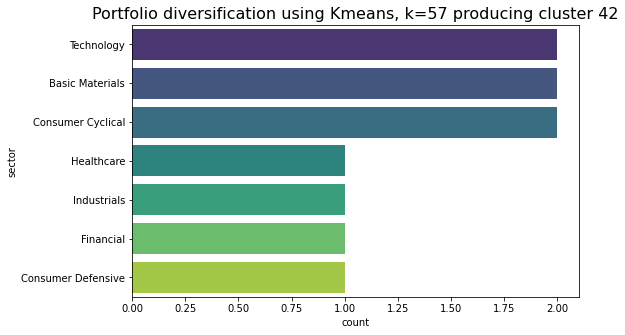

In [213]:
# visualizing diversification by kmeans
kmeans_portfolio = kmeans_df[kmeans_df['kmeans_cluster']==cluster]
order = kmeans_portfolio['sector'].value_counts().index.tolist()
plt.figure(figsize=(8,5))
sns.countplot(y='sector', data=kmeans_portfolio, orient='h', palette='viridis', order=order)
plt.title(f'Portfolio diversification using Kmeans, k={kmeans_random_best_k} producing cluster {cluster}', fontsize=16);

In [214]:
kmeans_portfolio

,EPS next Y,Dividend,Cash/sh,Book/sh,P/S,Forward P/E,Dividend pct,Sales past 5Y pct,ROA pct,Short Ratio,ROI pct,Sales Q/Q pct,Current Ratio,Payout pct,ticker,name,sector,industry,Price,kmeans_cluster
3,4.37,1.80,2.70,17.69,6.14,25.82,1.59,9.5,5.0,2.04,8.2,9.6,1.7,73.3,ABT,Abbott Laboratories,Healthcare,Medical Devices,112.95,42
9,4.72,1.80,3.28,30.08,3.26,25.23,1.51,9.2,3.7,1.72,9.2,1.3,1.1,43.1,AJG,Arthur J. Gallagher & Co.,Financial,Insurance Brokers,119.09,42
48,10.04,1.44,8.90,28.27,1.58,20.68,0.69,8.0,10.2,1.25,18.9,17.3,1.3,13.8,DG,Dollar General Corporation,Consumer Defensive,Discount Stores,207.72,42
64,4.76,1.04,3.31,18.97,2.19,19.36,1.13,7.5,7.8,1.39,12.0,13.2,1.9,26.5,FBHS,"Fortune Brands Home & Security, Inc.",Consumer Cyclical,"Furnishings, Fixtures & Appliances",92.15,42
67,7.45,1.92,2.26,22.67,3.23,15.44,1.67,7.2,5.0,1.44,12.3,6.9,1.7,44.8,FMC,FMC Corporation,Basic Materials,Agricultural Inputs,115.00,42
101,6.46,1.36,3.63,26.10,1.29,16.91,1.24,17.0,5.5,1.82,11.2,14.4,0.9,31.3,LDOS,"Leidos Holdings, Inc.",Technology,Information Technology Services,109.31,42
115,6.34,1.60,4.90,34.17,0.75,12.15,2.08,2.8,1.8,1.47,11.7,-2.0,1.3,104.7,MGA,Magna International Inc.,Consumer Cyclical,Auto Parts,77.05,42
127,4.34,1.60,6.25,28.22,4.62,14.37,2.57,7.4,6.4,1.03,10.1,16.8,2.8,24.5,NEM,Newmont Corporation,Basic Materials,Gold,62.31,42
143,4.18,0.24,1.53,29.54,0.97,18.61,0.31,9.3,4.8,1.40,7.4,-9.9,1.7,6.9,PWR,"Quanta Services, Inc.",Industrials,Engineering & Construction,77.81,42
151,5.90,1.73,7.78,30.07,4.71,21.67,1.35,9.4,7.5,1.49,7.0,-3.8,1.1,32.2,SAP,SAP SE,Technology,Software - Application,127.90,42


In [221]:
# confirmation that random kmeans selections are different from the domain knowledge selections
print(f'Kmeans portfolio companies =\n{kmeans_portfolio.ticker}')
print(f'Domain knowledge portfolio companies =\n{domain_df.ticker}')

Kmeans portfolio companies =
3       ABT
9       AJG
48       DG
64     FBHS
67      FMC
101    LDOS
115     MGA
127     NEM
143     PWR
151     SAP
Name: ticker, dtype: object
Domain knowledge portfolio companies =
2      ABBV
28      CAG
42     CSCO
77      GSK
104     LMT
121     MRK
145     RCI
170     TRP
180    VALE
183      VZ
Name: ticker, dtype: object


In [222]:
# export kmeans portfolio
#kmeans_portfolio.to_csv('datasets/kmeans_portfolio.csv', index=False)

In [223]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#kmeans_portfolio.to_csv('datasets/backups/kmeans_portfolio.csv', index=False)

In [11]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
#kmeans_portfolio = pd.read_csv('datasets/backups/kmeans_portfolio.csv')

### Portfolios Comparison (Human Portfolio vs AI Portfolio (Unspervised Learning Kmeans))

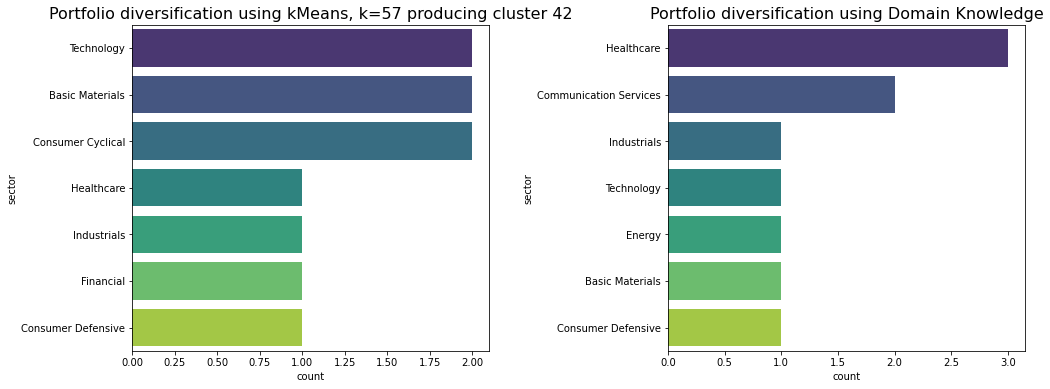

In [227]:
# comparison plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6), facecolor='white')
plt.subplots_adjust(hspace=0.3, wspace=0.5)

order = kmeans_portfolio['sector'].value_counts().index.tolist()
sns.countplot(y='sector', data=kmeans_portfolio, orient='h', palette='viridis', order=order, ax=ax1)
ax1.set_title(f'Portfolio diversification using kMeans, k={kmeans_random_best_k} producing cluster {cluster}', fontsize=16);

order = domain_df['sector'].value_counts().index.tolist()
sns.countplot(y='sector', data=domain_df, orient='h', palette='viridis', order=order, ax=ax2)
ax2.set_title('Portfolio diversification using Domain Knowledge', fontsize=16);
plt.show();

**Note:** Obviously these are two portfolios diversified differently, one using unsupervised machine learning method (Kmeans) and the other using domain knowledge. We shall proceed with the remaining of the data collection processes for each of these portfolios.

From the processes above, we can appreciate that the manual building of a portfolio although intuitive but took a lot of time to realize. On the other hand, using unsupervised machine learning, a portfolio that offers the same diversification could be created much faster.

## PART 3 DATA COLLECTION (continuation)

After establishing the portfolios and the companies within each, we continued with the data collection process for analyst's recommendations, news and historical prices. To ensure we collect data for all the companies in both portfolios, we will have to create a combined ticker list for looping.

In [12]:
# create combine ticker list
combined_ticker_list = domain_df.ticker.tolist() + kmeans_portfolio.ticker.tolist()
print(len(combined_ticker_list))
print(combined_ticker_list)

20
['ABBV', 'CAG', 'CSCO', 'GSK', 'LMT', 'MRK', 'RCI', 'TRP', 'VALE', 'VZ', 'ABT', 'AJG', 'DG', 'FBHS', 'FMC', 'LDOS', 'MGA', 'NEM', 'PWR', 'SAP']


### Scrapping Analyst's Recommendations

Similarly, we shall write the codes to test for one company to ensure we can get the required data before building and running a loop.

In [234]:
# pinging target using ticker = LDOS
ticker = 'LDOS'
url = 'https://finviz.com/quote.ashx?t='+ticker

res = Request(url,headers={'user-agent': 'analyst datascientist'})
resp = urlopen(res)
soup = BeautifulSoup(resp, features="lxml")
soup

<!DOCTYPE html>
<html>
<head>
<title>LDOS Leidos Holdings, Inc. Stock Quote</title>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=1024" name="viewport"/><meta content="Stock screener for investors and traders, financial visualizations." name="description"/>
<meta content="Stock Screener, Charts, Quotes, Maps, News, Financial Visualizations, Research, Trading Systems" name="keywords"/>
<meta content="no" http-equiv="imagetoolbar"/>
<meta content="no-cache" http-equiv="pragma"/>
<meta content="no-cache" http-equiv="cache-control"/>
<meta content="-1" http-equiv="Expires"/>
<link as="font" crossorigin="" href="/fonts/lato-v17-latin-ext_latin-regular.woff2" rel="preload"/>
<link as="font" crossorigin="" href="/fonts/lato-v17-latin-ext_latin-700.woff2" rel="preload"/>
<link href="/css/finviz.css?rev=154" rel="stylesheet" type="text/css"/>
<link href="/favicon_2x.png" rel="icon" sizes="32x32" type="image/png"/>
<link href="/favicon.png" rel="icon" sizes="16x16" 

In [235]:
# extracting only the target tags
target = soup.find_all('td', attrs = {'class' : 'fullview-ratings-inner'})
target

[<td class="fullview-ratings-inner"><table border="0" cellpadding="0" cellspacing="0">
 <tr class="body-table-rating-upgrade"><td align="left" width="120">Sep-23-20</td><td align="left" width="200"><b>Upgrade</b></td>
 <td align="left" width="250">Barclays</td>
 <td align="left" width="250">Equal Weight → Overweight</td>
 <td align="left" width="150">$109 → $110</td>
 </tr>
 </table>
 </td>,
 <td class="fullview-ratings-inner"><table border="0" cellpadding="0" cellspacing="0">
 <tr class="body-table-rating-upgrade"><td align="left" width="120">Sep-22-20</td><td align="left" width="200"><b>Upgrade</b></td>
 <td align="left" width="250">JP Morgan</td>
 <td align="left" width="250">Neutral → Overweight</td>
 <td align="left" width="150">$115</td>
 </tr>
 </table>
 </td>,
 <td class="fullview-ratings-inner"><table border="0" cellpadding="0" cellspacing="0">
 <tr class="body-table-rating-neutral"><td align="left" width="120">Aug-21-20</td><td align="left" width="200"><b>Initiated</b></td>
 

In [236]:
# extracting each row and put into a df
out=[]
for i in range(len(target)):
    td = target[i].find_all('td')
    out = [x.text for x in td]
    df = pd.DataFrame(out).T
    if i == 0:
        one_comp_df = df
    else:
        one_comp_df = one_comp_df.append(df, ignore_index=True)
        
# rename columns and add ticker column
one_comp_df.rename(columns={0:'date', 1: 'recom_type', 2: 'source', 3: 'recom_action', 4: 'target'}, inplace=True)
one_comp_df['ticker'] = ticker
one_comp_df.sample(frac=1).head()

,date,recom_type,source,recom_action,target,ticker
19,Oct-05-17,Resumed,Jefferies,Buy,$75,LDOS
16,Feb-26-18,Reiterated,Citigroup,Buy,$71 → $75,LDOS
11,Sep-20-19,Initiated,Barclays,Equal Weight,$97,LDOS
13,Jun-03-19,Initiated,Morgan Stanley,Equal-Weight,$75,LDOS
18,Oct-25-17,Upgrade,Wells Fargo,Market Perform → Outperform,,LDOS


In [237]:
# use regex lambda to clean up
one_comp_df['target'] = one_comp_df['target'].apply(lambda x: re.sub('\s\D\s','-', x).replace('$',''))
one_comp_df['recom_action'] = one_comp_df['recom_action'].apply(lambda x: re.sub('\W','-', x).replace('---', ' to '))

# correct dtype for date
one_comp_df['date'] = pd.to_datetime(one_comp_df['date'])

**Note:** There are two fields representing the analyst's recommendations. However, the `recom_action` field consists of too many variations of the similar actions written in different ways. Therefore, the `recom_type` field will be more useful to be used in modeling. As such, we will need to convert this field into an ordinal variable.

In [238]:
# ordinal encode recom_type
one_comp_df['recom_type_ordinal'] = one_comp_df['recom_type'].map({'Upgrade' : 5,
                                                                   'Resumed' : 4,
                                                                   'Reiterated': 3,                                                                   
                                                                   'Initiated' : 2,
                                                                   'Downgrade' : 1})
one_comp_df.sample(frac=1).head()

,date,recom_type,source,recom_action,target,ticker,recom_type_ordinal
18,2017-10-25,Upgrade,Wells Fargo,Market-Perform to Outperform,,LDOS,5
10,2019-09-24,Initiated,JP Morgan,Neutral,95,LDOS,2
19,2017-10-05,Resumed,Jefferies,Buy,75,LDOS,4
6,2020-03-03,Upgrade,Wells Fargo,Equal-Weight to Overweight,120,LDOS,5
17,2017-11-21,Resumed,Stifel,Hold,68,LDOS,4


#### Making a loop for mass extraction

Once the above was confirmed, we defined a loop to mass extract data.

In [239]:
# mass scrapping loop function
fail_tickers = []

def analyst_recom_scrape(ticker):
    try:
        one_comp_df = []

        url = 'https://finviz.com/quote.ashx?t='+ticker
        res = Request(url,headers={'user-agent': 'money datascientist'})
        resp = urlopen(res)
        status_code = resp.getcode()
        if status_code != 200:
            print('error', status_code, url)
            pass
        else:
            print('trying', url)
            soup = BeautifulSoup(resp, features="lxml")
 
            # extracting only the target tags
            target = soup.find_all('td', attrs = {'class' : 'fullview-ratings-inner'})

            if target is None:
                print('no data', ticker)
                pass
            else:
                # extracting each row and put into a df
                out=[]
                for i in range(len(target)):
                    td = target[i].find_all('td')
                    out = [x.text for x in td]
                    df = pd.DataFrame(out).T
                    if i == 0:
                        one_comp_df = df
                    else:
                        one_comp_df = one_comp_df.append(df, ignore_index=True)

                # rename columns and add ticker column
                one_comp_df.rename(columns={0:'date', 1: 'recom_type', 2: 'source', 3: 'recom_action', 4: 'target'}, inplace=True)
                one_comp_df['ticker'] = ticker

                # use regex lambda to clean up
                one_comp_df['target'] = one_comp_df['target'].apply(lambda x: re.sub('\s\D\s','-', x).replace('$',''))
                one_comp_df['recom_action'] = one_comp_df['recom_action'].apply(lambda x: re.sub('\W','-', x).replace('---', ' to '))
                
                # correct dtype for date
                one_comp_df['date'] = pd.to_datetime(one_comp_df['date'])

                # ordinal encode recom_type
                one_comp_df['recom_type_ordinal'] = one_comp_df['recom_type'].map({'Upgrade' : 5,
                                                                                   'Resumed' : 4,
                                                                                   'Reiterated': 3,
                                                                                   'Initiated' : 2,
                                                                                   'Downgrade' : 1})
                
    except:
        print('Fail', ticker)
        fail_tickers.append(ticker)

    return one_comp_df

In [240]:
# call the function, iterate for all tickers, append each ticker result to one df
i = 0
for ticker in combined_ticker_list:
    if i==0:
        all_comp_df = analyst_recom_scrape(ticker)
        i+=1
    else:
        all_comp_df = all_comp_df.append(analyst_recom_scrape(ticker))
        
    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(2,3)
    ntime.sleep(sleep_duration)
    print('Success', ticker, 'sleep', sleep_duration)
    
all_comp_df.reset_index(drop=True, inplace=True)

trying https://finviz.com/quote.ashx?t=ABBV
Success ABBV sleep 2
trying https://finviz.com/quote.ashx?t=CAG
Success CAG sleep 2
trying https://finviz.com/quote.ashx?t=CSCO
Success CSCO sleep 2
trying https://finviz.com/quote.ashx?t=GSK
Success GSK sleep 2
trying https://finviz.com/quote.ashx?t=LMT
Success LMT sleep 3
trying https://finviz.com/quote.ashx?t=MRK
Success MRK sleep 3
trying https://finviz.com/quote.ashx?t=RCI
Success RCI sleep 3
trying https://finviz.com/quote.ashx?t=TRP
Success TRP sleep 2
trying https://finviz.com/quote.ashx?t=VALE
Success VALE sleep 2
trying https://finviz.com/quote.ashx?t=VZ
Success VZ sleep 3
trying https://finviz.com/quote.ashx?t=ABT
Success ABT sleep 2
trying https://finviz.com/quote.ashx?t=AJG
Success AJG sleep 2
trying https://finviz.com/quote.ashx?t=DG
Success DG sleep 2
trying https://finviz.com/quote.ashx?t=FBHS
Success FBHS sleep 2
trying https://finviz.com/quote.ashx?t=FMC
Success FMC sleep 3
trying https://finviz.com/quote.ashx?t=LDOS
Success

**NOTE: The error message above (if any) was due to a manual interruption to the code execution. The codes work perfectly, it was manually interrupted because we have to run this notebook again to generate the in-notebook visuals to go with the textual explanation of how this works. The desire results were obtained and exported to CSV files for subsequent steps.**

In [241]:
# checking if any tickers failed
print('Failed tickers = ', fail_tickers)

Failed tickers =  []


**NOTE: The "Failed tickers" (if any) reported above was due to a manual interruption to the code execution. The codes work perfectly, it was manually interrupted because we have to run this notebook again after a kernel refresh to generate the in-notebook visuals to go with the textual explanation of how this works. The desire results (with no fail tickers) were obtained in previous full run and were exported to CSV files for subsequent steps.**

**NOTE: Some codes below are commented out to prevent accidental execution that will overwrite the previously extracted data used for the rest of this project.**

In [243]:
# exporting result to csv file as backup
#all_comp_df.to_csv('datasets/analyst_recom.csv', index=False)

In [244]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#all_comp_df.to_csv('datasets/backups/analyst_recom.csv', index=False)

In [245]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
#all_comp_df = pd.read_csv('datasets/backups/analyst_recom.csv')

#### Data Cleaning and EDA

In [15]:
# read in last good backup file
analyst_recom_df = pd.read_csv('datasets/backups/analyst_recom.csv')
print(analyst_recom_df.shape)
analyst_recom_df.sample(frac=1).head()

(400, 7)


,date,recom_type,source,recom_action,target,ticker,recom_type_ordinal
228,2020-03-23,Upgrade,Raymond James,Mkt-Perform to Strong-Buy,NaN,AJG,5
153,2020-02-24,Upgrade,Goldman,Sell to Neutral,NaN,TRP,5
139,2015-10-23,Reiterated,Barclays,Equal-Weight,36-40,RCI,3
383,2020-10-26,Downgrade,JP Morgan,Overweight to Neutral,NaN,SAP,1
397,2018-07-20,Reiterated,Barclays,Overweight,134-128,SAP,3


In [16]:
# checking types and number of recom_type
analyst_recom_df['recom_type'].value_counts()

Upgrade       128
Downgrade     107
Initiated      81
Reiterated     47
Resumed        37
Name: recom_type, dtype: int64

In [17]:
# check dtypes
analyst_recom_df.dtypes

date                  object
recom_type            object
source                object
recom_action          object
target                object
ticker                object
recom_type_ordinal     int64
dtype: object

In [18]:
# set Date to datetime
analyst_recom_df['date'] = pd.to_datetime(analyst_recom_df['date'])

In [19]:
# checking null values
analyst_recom_df.isnull().sum()

date                    0
recom_type              0
source                  0
recom_action            0
target                192
ticker                  0
recom_type_ordinal      0
dtype: int64

In [20]:
# dropping target null column and recom_action column since not needed
analyst_recom_df.drop(['target', 'recom_action'], axis=1, inplace=True)

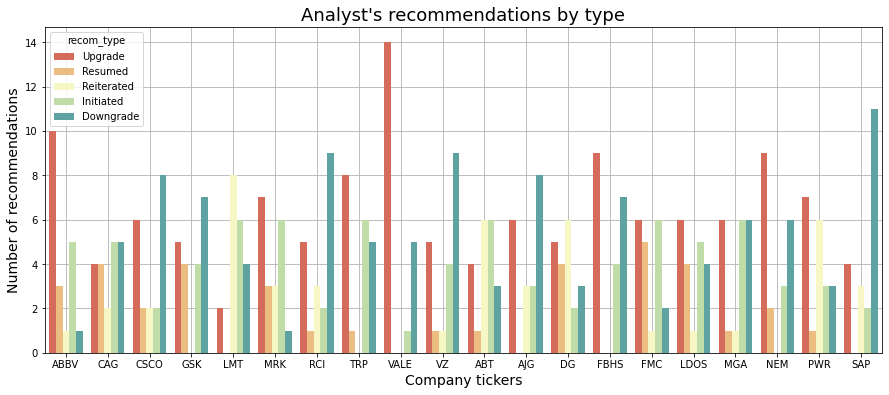

In [21]:
# visualize recom type
plt.figure(figsize=(15,6))
sns.countplot(x='ticker', data=final_recom_df, hue='recom_type', palette='Spectral',
              hue_order=['Upgrade', 'Resumed', 'Reiterated', 'Initiated', 'Downgrade'],
              zorder=3)
plt.title('Analyst\'s recommendations by type', fontsize=18)
plt.xlabel('Company tickers', fontsize=14)
plt.ylabel('Number of recommendations', fontsize=14)
plt.grid(zorder=0);

**Note:** From the plot above, we can see that there is a good spread of analyst recommendations for the companies within our various portfolios. Analyst recommendations tend to have an effect on price movement where an upgrade recommendation tends to lift prices while a downgrade recommendation tends to depress prices.

In [22]:
final_recom_df[['recom_type', 'recom_type_ordinal']].value_counts().sort_values(ascending=False)

recom_type  recom_type_ordinal
Upgrade     5                     128
Downgrade   1                     107
Initiated   2                      81
Reiterated  3                      47
Resumed     4                      37
dtype: int64

In [24]:
print(final_recom_df.date.min())
print(final_recom_df.date.max())

2015-10-23 00:00:00
2021-01-21 00:00:00


**Note:** The date rate spread of analyst's recommendation is about 5 yrs collectively for the companies in our portfolios. This is due to the limited amount of recommendations that were available on the website. We do not see this as an issue because generally prices react to more recent recommendations than old recommendations. As an investor, we generally do not look beyond 1-2 financial years.

In [108]:
# final view before export
analyst_recom_df

,date,recom_type,source,ticker,recom_type_ordinal
0,2020-11-10,Resumed,Bernstein,ABBV,4
1,2020-09-29,Initiated,Berenberg,ABBV,2
2,2020-06-23,Upgrade,Atlantic Equities,ABBV,5
3,2020-06-09,Upgrade,Wolfe Research,ABBV,5
4,2020-06-02,Upgrade,Argus,ABBV,5
...,...,...,...,...,...
395,2019-04-09,Downgrade,HSBC Securities,SAP,1
396,2019-02-04,Downgrade,BofA/Merrill,SAP,1
397,2018-07-20,Reiterated,Barclays,SAP,3
398,2018-06-01,Initiated,Jefferies,SAP,2


In [23]:
# exporting result to csv file as backup
final_recom_df.to_csv('datasets/cleaned_complete_scrape_analyst_recom.csv', index=False)

In [25]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#final_recom_df.to_csv('datasets/backups/cleaned_complete_scrape_analyst_recom.csv', index=False)

In [ ]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
#final_recom_df = pd.read_csv('datasets/backups/cleaned_complete_scrape_analyst_recom.csv')

### Scrapping News Articles

Similarly, we shall write the codes to test for one company to ensure we can get the required data before building and running a loop.

In [246]:
# set parameters
ticker = 'FBHS'
finviz_url = 'https://finviz.com/quote.ashx?t='

In [247]:
# pinging target using ticker = FBHS
url = finviz_url + ticker
res = Request(url, headers={'user-agent': 'money datascientist'})
resp = urlopen(res)
status_code = resp.getcode()
status_code
soup = BeautifulSoup(resp, features="lxml")

In [248]:
# extracting only the target tags
news_table = soup.find(id='news-table')
news_table

<table border="0" cellpadding="1" cellspacing="0" class="fullview-news-outer" id="news-table" width="100%">
<tr><td align="right" style="white-space:nowrap" width="130">Jan-20-21 12:51AM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/look-fair-value-fortune-brands-055141470.html" target="_blank">A Look At The Fair Value Of Fortune Brands Home &amp; Security, Inc. (NYSE:FBHS)</a></div><div class="news-link-right"><span style="color:#aa6dc0;font-size:9px"> Simply Wall St.</span></div></div></td></tr>
<tr><td align="right" style="white-space:nowrap" width="130">Jan-19-21 08:56AM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/heres-why-worth-investing-allegion-135601130.html" target="_blank">Here's Why it's Worth Investing in Allegion (ALLE) Stock Now</a></div><div class="news-link-right"><span 

In [249]:
# find the required table rows
news_table.findAll('tr')

[<tr><td align="right" style="white-space:nowrap" width="130">Jan-20-21 12:51AM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/look-fair-value-fortune-brands-055141470.html" target="_blank">A Look At The Fair Value Of Fortune Brands Home &amp; Security, Inc. (NYSE:FBHS)</a></div><div class="news-link-right"><span style="color:#aa6dc0;font-size:9px"> Simply Wall St.</span></div></div></td></tr>,
 <tr><td align="right" style="white-space:nowrap" width="130">Jan-19-21 08:56AM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/heres-why-worth-investing-allegion-135601130.html" target="_blank">Here's Why it's Worth Investing in Allegion (ALLE) Stock Now</a></div><div class="news-link-right"><span style="color:#aa6dc0;font-size:9px"> Zacks</span></div></div></td></tr>,
 <tr><td align="right" style="wh

In [250]:
# extracting each row and put into a df
df_tr = news_table.findAll('tr')

for i, table_row in enumerate(df_tr):
    a_text = table_row.a.text
    td_text = table_row.td.text
    td_text = td_text.strip()
    print(a_text,'(',td_text,')')

A Look At The Fair Value Of Fortune Brands Home & Security, Inc. (NYSE:FBHS) ( Jan-20-21 12:51AM )
Here's Why it's Worth Investing in Allegion (ALLE) Stock Now ( Jan-19-21 08:56AM )
Benzinga's Top Ratings Upgrades, Downgrades For January 14, 2021 ( Jan-14-21 10:11AM )
5 Industrial Stocks Near 52-Week Highs That Can Scale Higher ( Jan-13-21 09:38AM )
Fortune Brands Sets Date for Fourth Quarter and Full-Year 2020 Earnings Announcement and Investor Conference Call ( Jan-11-21 04:05PM )
Moen Launches Industry-First Smart Water Network to Provide Convenience and Security; Experience it at CES 2021 ( 07:10AM )
Allegion (ALLE) Buys Yonomi, Strengthens Product Offerings ( Jan-08-21 09:43AM )
Fortune Brands (FBHS) Displays Solid Prospects, Risks Persist ( Dec-30-20 08:32AM )
5 Industrial Stocks That Braved the Coronavirus-Induced Mayhem ( Dec-28-20 09:21AM )
Is FBHS A Good Stock To Buy According To Hedge Funds? ( Dec-21-20 04:58PM )
Fortune Brands Appoints Susan Saltzbart Kilsby as Non-Executiv

In [251]:
# Iterate through the news_table to organize the news
parsed_news = []
#for file_name, news_table in news_table.items():
for x in df_tr:
    text = x.a.get_text() 
    date_scrape = x.td.text.split()

    if len(date_scrape) == 1:
        time = date_scrape[0]            
    else:
        date = date_scrape[0]
        time = date_scrape[1]

    parsed_news.append([ticker, date, time, text])
parsed_news

[['FBHS',
  'Jan-20-21',
  '12:51AM',
  'A Look At The Fair Value Of Fortune Brands Home & Security, Inc. (NYSE:FBHS)'],
 ['FBHS',
  'Jan-19-21',
  '08:56AM',
  "Here's Why it's Worth Investing in Allegion (ALLE) Stock Now"],
 ['FBHS',
  'Jan-14-21',
  '10:11AM',
  "Benzinga's Top Ratings Upgrades, Downgrades For January 14, 2021"],
 ['FBHS',
  'Jan-13-21',
  '09:38AM',
  '5 Industrial Stocks Near 52-Week Highs That Can Scale Higher'],
 ['FBHS',
  'Jan-11-21',
  '04:05PM',
  'Fortune Brands Sets Date for Fourth Quarter and Full-Year 2020 Earnings Announcement and Investor Conference Call'],
 ['FBHS',
  'Jan-11-21',
  '07:10AM',
  'Moen Launches Industry-First Smart Water Network to Provide Convenience and Security; Experience it at CES 2021'],
 ['FBHS',
  'Jan-08-21',
  '09:43AM',
  'Allegion (ALLE) Buys Yonomi, Strengthens Product Offerings'],
 ['FBHS',
  'Dec-30-20',
  '08:32AM',
  'Fortune Brands (FBHS) Displays Solid Prospects, Risks Persist'],
 ['FBHS',
  'Dec-28-20',
  '09:21AM',

In [252]:
# renaming columns
parsed_news_df = pd.DataFrame(parsed_news)
parsed_news_df = parsed_news_df.rename(columns={0: 'ticker', 1: 'date', 2: 'time', 3: 'parsed_news'})
parsed_news_df['date'] = pd.to_datetime(parsed_news_df['date'])
parsed_news_df.sample(frac=1).head() 

,ticker,date,time,parsed_news
37,FBHS,2020-10-28,04:05PM,Fortune Brands Reports Strong 3Q Sales and Pro...
67,FBHS,2020-09-01,09:56AM,Fortune Brands Rises 28.7% YTD: What's Driving...
99,FBHS,2020-05-12,07:48AM,Fortune Brands Has Leading Brands Across Plumb...
66,FBHS,2020-09-10,09:31AM,"Benzinga's Top Upgrades, Downgrades For Septem..."
93,FBHS,2020-06-16,08:58AM,Fiberon Launches Promenade PVC Decking


#### Making a loop for mass extraction

Once the above was confirmed, we defined a loop to mass extract data.

In [253]:
# mass scrapping loop function
fail_tickers = []

def news_scrap(ticker):
    
    try:
        parsed_news_df = []

        # Parameters
        finviz_url = 'https://finviz.com/quote.ashx?t='
        url = finviz_url + ticker
        res = Request(url,headers={'user-agent': 'money datascientist'})
        resp = urlopen(res)
        status_code = resp.getcode()
        if status_code != 200:
            print('error', status_code, url)
            pass
        else:
            print('trying', url)
            soup = BeautifulSoup(resp, features="lxml")
            news_table = soup.find(id='news-table')
            if news_table is None:
                print('no data', ticker)
                pass
            else:
                df_tr = news_table.findAll('tr')

                #printing just to check if it is working
                #print ('Recent News Headlines for {}: '.format(ticker), '\n')
                #for i, table_row in enumerate(df_tr):
                #    a_text = table_row.a.text
                #    td_text = table_row.td.text
                #    td_text = td_text.strip()
                #    print(a_text,'(',td_text,')')
                #    if i == n-1:
                #        break

                # Iterate through the news_table to organize the news
                parsed_news = []
                for x in df_tr:
                    text = x.a.get_text() 
                    date_scrape = x.td.text.split()

                    if len(date_scrape) == 1:
                        time = date_scrape[0]            
                    else:
                        date = date_scrape[0]
                        time = date_scrape[1]

                    parsed_news.append([ticker, date, time, text])

                # renaming columns
                parsed_news_df = pd.DataFrame(parsed_news)
                parsed_news_df = parsed_news_df.rename(columns={0: 'ticker', 1: 'date', 2: 'time', 3: 'parsed_news'})
                parsed_news_df['date'] = pd.to_datetime(parsed_news_df['date'])

    except:
        print('Fail', ticker)
        fail_tickers.append(ticker)
    return parsed_news_df

In [254]:
# call the function, iterate for all tickers, append each ticker result to one df
i = 0
for ticker in combined_ticker_list:
    if i==0:
        all_comp_df = news_scrap(ticker)
        i+=1
    else:
        all_comp_df = all_comp_df.append(news_scrap(ticker))
        
    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(2,3)
    ntime.sleep(sleep_duration)
    print('Success', ticker, 'sleep', sleep_duration)
    
all_comp_df.reset_index(drop=True, inplace=True)

trying https://finviz.com/quote.ashx?t=ABBV
Success ABBV sleep 3
trying https://finviz.com/quote.ashx?t=CAG
Success CAG sleep 2
trying https://finviz.com/quote.ashx?t=CSCO
Success CSCO sleep 2
trying https://finviz.com/quote.ashx?t=GSK
Success GSK sleep 2
trying https://finviz.com/quote.ashx?t=LMT
Success LMT sleep 2
trying https://finviz.com/quote.ashx?t=MRK
Success MRK sleep 2
trying https://finviz.com/quote.ashx?t=RCI
Success RCI sleep 3
trying https://finviz.com/quote.ashx?t=TRP
Success TRP sleep 2
trying https://finviz.com/quote.ashx?t=VALE
Success VALE sleep 3
trying https://finviz.com/quote.ashx?t=VZ
Success VZ sleep 3
trying https://finviz.com/quote.ashx?t=ABT
Success ABT sleep 2
trying https://finviz.com/quote.ashx?t=AJG
Success AJG sleep 2
trying https://finviz.com/quote.ashx?t=DG
Success DG sleep 3
trying https://finviz.com/quote.ashx?t=FBHS
Success FBHS sleep 3
trying https://finviz.com/quote.ashx?t=FMC
Success FMC sleep 3
trying https://finviz.com/quote.ashx?t=LDOS
Success

**NOTE: The error message above (if any) was due to a manual interruption to the code execution. The codes work perfectly, it was manually interrupted because we have to run this notebook again to generate the in-notebook visuals to go with the textual explanation of how this works. The desire results were obtained and exported to CSV files for subsequent steps.**

In [255]:
# checking if any tickers failed
print('Failed tickers = ', fail_tickers)

Failed tickers =  []


**NOTE: The "Failed tickers" (if any) reported above was due to a manual interruption to the code execution. The codes work perfectly, it was manually interrupted because we have to run this notebook again after a kernel refresh to generate the in-notebook visuals to go with the textual explanation of how this works. The desire results (with no fail tickers) were obtained in previous full run and were exported to CSV files for subsequent steps.**

**NOTE: Some codes below are commented out to prevent accidental execution that will overwrite the previously extracted data used for the rest of this project.**

In [256]:
# exporting result to csv file as backup
#all_comp_df.to_csv('datasets/scrape_parsed_news.csv', index=False)

In [258]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#all_comp_df.to_csv('datasets/backups/scrape_parsed_news.csv', index=False)

In [260]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
#all_comp_df = pd.read_csv('datasets/backups/scrape_parsed_news.csv')

#### Data Cleaning and EDA

In [27]:
# read in last good backup file
news_df = pd.read_csv('datasets/backups/scrape_parsed_news.csv')
print(news_df.shape)
news_df.sample(frac=1).head()

(2000, 4)


,ticker,date,time,parsed_news
934,VZ,2021-01-11,07:50AM,8 Stocks To Watch At CES 2021
1701,NEM,2021-01-16,02:13AM,The Returns At PC Connection (NASDAQ:CNXN) Pro...
1892,PWR,2020-01-22,07:02AM,"Apple has soared out of the value realm, but y..."
1484,FMC,2020-05-04,08:48AM,Why Earnings Season Could Be Great for FMC Cor...
132,CAG,2020-12-27,06:20PM,Barry Rosenstein and Jana Partners: Top 10 Sto...


In [28]:
# check dtypes
news_df.dtypes

ticker         object
date           object
time           object
parsed_news    object
dtype: object

In [29]:
# set Date to datetime
news_df['date'] = pd.to_datetime(news_df['date'])

In [30]:
# check for NaN
news_df.isnull().sum()

ticker         0
date           0
time           0
parsed_news    0
dtype: int64

Minimum length:  15
Maximum length:  247


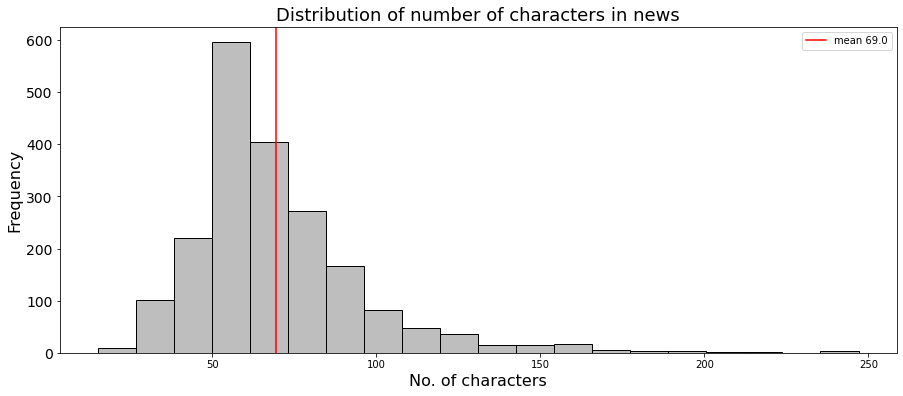

In [32]:
# calculations for length of news
lengths = [len(text) for text in news_df['parsed_news']]
print('Minimum length: ', min(lengths))
print('Maximum length: ', max(lengths))

# Plotting the text lengths
plt.figure(figsize = (15,6), facecolor='white')
sns.histplot(lengths, kde = False, bins = 20, color = "darkgrey")
plt.axvline(np.mean(lengths), color = "red", label="mean "+str(round(np.mean(lengths))))
plt.legend()
plt.title("Distribution of number of characters in news", size = 18)
plt.xlabel("No. of characters", size = 16)
plt.ylabel("Frequency", size = 16)
plt.yticks(size = 14);

In [75]:
# view examples of shortest and longest news
print('Shortest news:')
print(news_df['parsed_news'][news_df['parsed_news'].str.len().sort_values(ascending=True).head(1).index], '\n')
print('Longest news:')
print(news_df['parsed_news'][news_df['parsed_news'].str.len().sort_values(ascending=False).head(1).index])

Shortest news:
1977    Why SAP Is Down
Name: parsed_news, dtype: object 

Longest news:
566    FDA Grants Priority Review to Mercks Supplemen...
Name: parsed_news, dtype: object


**Note:** We can see that the length of news articles title range from 15 to 247 characters with a mean of 69 characters. Although we are using only the title of the news articles, it is generally deem to be sufficient as the style of stock market articles are written in a way to reflect the positive or negative effect on a company right off the bat to attract readers. Moreover, for the scope of this project, it will not be feasible to extract, parse and process all the articles words.

Looking at the above examples of shortest and longest articles titles, we can confirm that even the shortest title with only 15 characters had clearly illustrated the intent of the article "Why SAP Is Down" to be a negative effect. On the other hand, the longest title also illustrated the intent of the article to be a positive effect.

It will not be possible to derive the intent manually therefore we will be using VADER sentimental analysis package to do the heavy lifting in the next section.

In [34]:
print(news_df.date.min())
print(news_df.date.max())

2020-01-03 00:00:00
2021-01-22 00:00:00


**Note:** The date rate spread of news articles is about 1 yr collectively for the companies in our portfolios. This is due to the limited amount of news that were available on the website. We do not see this as an issue because generally prices react to more recent news than old news. As an investor, we generally do not look beyond 1-2 financial years.

### VADER Sentiment Scores

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License]. All credits goes to the authors and contributors cited as:

>VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text
>(by C.J. Hutto and Eric Gilbert)
>Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

**About the Scoring**

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values are (cited: 'https://github.com/cjhutto/vaderSentiment#about-the-scoring'):

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1 or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

In [76]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
senti_df = news_df

# return a float for sentiment strength based on the input text.
# Positive values are positive valence, negative value are negative valence.
scores = senti_df['parsed_news'].apply(analyzer.polarity_scores).tolist()
# the above return a list of scores from VADER

# make a df with sentimental scores and join with news df
scores_df = pd.DataFrame(scores)
senti_df = senti_df.join(scores_df)
print(senti_df.shape)
senti_df.sample(frac=1).head()

(2000, 8)


,ticker,date,time,parsed_news,neg,neu,pos,compound
494,LMT,2020-12-08,04:03PM,"Boeing, Kratos To Build Skyborg Drones For Air...",0.00,1.000,0.000,0.0000
1707,NEM,2021-01-05,08:55AM,Newmont to Provide Reserves and Exploration Up...,0.00,0.759,0.241,0.2263
1122,AJG,2020-12-09,09:24AM,Arthur J. Gallagher (AJG) Announces Cool Insur...,0.00,0.753,0.247,0.3182
996,VZ,2020-12-18,05:58PM,5G Auction Soars to $34 Billion With Verizon L...,0.00,1.000,0.000,0.0000
415,LMT,2021-01-12,03:03PM,More companies pause political donations follo...,0.32,0.680,0.000,-0.5106


In [77]:
# verifying age of news articles
print('Oldest news dated :', senti_df.date.min())
print('Latest news dated :', senti_df.date.max())

Oldest news dated : 2020-01-03 00:00:00
Latest news dated : 2021-01-22 00:00:00


In [78]:
# convert/organize as dict for each ticker
unique_ticker = senti_df['ticker'].unique().tolist()
senti_dict = {name: senti_df[senti_df['ticker']==name] for name in unique_ticker}
print(len(senti_dict))
senti_dict

20


{'ABBV':    ticker       date     time  \
 0    ABBV 2021-01-20  05:45PM   
 1    ABBV 2021-01-20  01:00PM   
 2    ABBV 2021-01-20  12:15PM   
 3    ABBV 2021-01-19  07:15AM   
 4    ABBV 2021-01-15  09:00AM   
 5    ABBV 2021-01-15  08:27AM   
 6    ABBV 2021-01-14  05:45PM   
 7    ABBV 2021-01-13  10:28AM   
 8    ABBV 2021-01-13  09:11AM   
 9    ABBV 2021-01-13  07:30AM   
 10   ABBV 2021-01-13  06:03AM   
 11   ABBV 2021-01-12  05:45PM   
 12   ABBV 2021-01-12  04:05PM   
 13   ABBV 2021-01-12  08:00AM   
 14   ABBV 2021-01-12  06:45AM   
 15   ABBV 2021-01-11  05:45PM   
 16   ABBV 2021-01-09  06:10AM   
 17   ABBV 2021-01-09  06:07AM   
 18   ABBV 2021-01-09  01:00AM   
 19   ABBV 2021-01-08  07:56PM   
 20   ABBV 2021-01-08  10:18AM   
 21   ABBV 2021-01-08  08:54AM   
 22   ABBV 2021-01-08  08:47AM   
 23   ABBV 2021-01-07  08:45AM   
 24   ABBV 2021-01-07  08:45AM   
 25   ABBV 2021-01-07  08:42AM   
 26   ABBV 2021-01-06  05:32PM   
 27   ABBV 2021-01-06  12:10PM   
 28   

In [79]:
# calculating mean score and putting into df for easy viewing
# initiate a blank df
senti_mean_df = pd.DataFrame(columns={'ticker': '', 'date': '', 'compound': ''})

# list of values
for ticker in unique_ticker: 
    data = senti_dict[ticker]
    # calculate mean of sentiments of all news from this ticker and put into a df
    mean_df = pd.DataFrame(data[['ticker', 'date', 'compound']].groupby(['ticker', 'date']).compound.mean()).reset_index()
    # merging the compound scores into senti_mean_df
    senti_mean_df = pd.concat([senti_mean_df, mean_df])

senti_mean_df.reset_index(drop=True)

,ticker,date,compound
0,ABBV,2020-11-24,0.180600
1,ABBV,2020-11-25,0.332600
2,ABBV,2020-11-27,0.127550
3,ABBV,2020-11-28,0.624900
4,ABBV,2020-11-29,0.000000
...,...,...,...
1083,SAP,2021-01-15,0.236533
1084,SAP,2021-01-19,0.159100
1085,SAP,2021-01-20,0.000000
1086,SAP,2021-01-21,0.273200


In [84]:
#create sentiment interpretation column in df
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05
senti_mean_df['Interpretation'] = ['Positive' if x>=0.05 else 'Neutral' if x>-0.05 and x<0.05 else \
                                   'Negative' for x in senti_mean_df['compound']]
print(senti_mean_df.shape)
senti_mean_df.sample(frac=1).head()

(1088, 4)


,ticker,date,compound,Interpretation
49,NEM,2021-01-05,0.226300,Positive
17,ABBV,2020-12-15,0.051033,Positive
17,VZ,2021-01-09,0.000000,Neutral
29,SAP,2020-12-31,0.102700,Positive
26,ABT,2020-12-05,-0.381800,Negative


In [83]:
# checking dtypes
senti_mean_df.dtypes

ticker                    object
date              datetime64[ns]
compound                 float64
Interpretation            object
dtype: object

In [109]:
# final view before export
senti_mean_df

,ticker,date,compound,Interpretation
0,ABBV,2020-11-24,0.180600,Positive
1,ABBV,2020-11-25,0.332600,Positive
2,ABBV,2020-11-27,0.127550,Positive
3,ABBV,2020-11-28,0.624900,Positive
4,ABBV,2020-11-29,0.000000,Neutral
...,...,...,...,...
34,SAP,2021-01-15,0.236533,Positive
35,SAP,2021-01-19,0.159100,Positive
36,SAP,2021-01-20,0.000000,Neutral
37,SAP,2021-01-21,0.273200,Positive


In [85]:
# exporting result to csv file for backup
#senti_mean_df.to_csv('datasets/news_senti.csv', index=False)

In [86]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#senti_mean_df.to_csv('datasets/backups/news_senti.csv', index=False)

In [ ]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
#senti_mean_df = pd.read_csv('datasets/backups/news_senti.csv')

### Extracting Prices using yfinance API

Ever since Yahoo! finance decommissioned their historical data API, many programs that relied on it stop working.

yfinance aims to solve this problem by offering a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance.

Instead of rebuilding a scrape bot we elected to use yfinance API to extract historical daily prices. All credits goes to the original contributor. (https://github.com/ranaroussi/yfinance)

#### Extracting historical daily prices

Here we tested for one company to ensure we get the required data before building and running a loop.

In [261]:
# setting test target using ticker=NEM
target_ticker = yf.Ticker('NEM')

In [262]:
# get stock info
print(target_ticker.info)

{'zip': '80111', 'sector': 'Basic Materials', 'fullTimeEmployees': 16600, 'longBusinessSummary': "Newmont Corporation engages in the production and exploration of gold, copper, silver, zinc, and lead. The company has operations and/or assets in the United States, Canada, Mexico, Dominican Republic, Peru, Suriname, Argentina, Chile, Australia, and Ghana. As of December 31, 2019, it had proven and probable gold reserves of 100.2 million ounces and land position of 68,300 square kilometers. The company has a strategic alliance agreement with Kirkland Lake Gold Ltd. to assess regional exploration opportunities around the company's Timmins properties and Kirkland's Holt Complex in Ontario, Canada. Newmont Corporation was founded in 1916 and is headquartered in Greenwood Village, Colorado.", 'city': 'Greenwood Village', 'phone': '303-863-7414', 'state': 'CO', 'country': 'United States', 'companyOfficers': [], 'website': 'http://www.newmont.com', 'maxAge': 1, 'address1': '6363 South Fiddlerâ\

In [263]:
# accessing keys of history object
target_ticker.history().keys()

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [264]:
# get historical market data
hist = target_ticker.history(period="max")
print(hist.shape)
hist

(10303, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-17,0.000000,6.400308,6.133629,6.318253,519300.0,0.0,0.0
1980-03-18,0.000000,6.482360,5.846432,6.482360,659200.0,0.0,0.0
1980-03-19,0.000000,6.666984,6.359277,6.625957,408000.0,0.0,0.0
1980-03-20,0.000000,6.769555,6.502875,6.646472,607100.0,0.0,0.0
1980-03-21,0.000000,6.666983,6.359276,6.564414,229100.0,0.0,0.0
...,...,...,...,...,...,...,...
2021-01-15,62.630001,63.430000,61.779999,61.860001,5582600.0,0.0,0.0
2021-01-19,62.400002,62.599998,61.410000,61.849998,5270200.0,0.0,0.0
2021-01-20,62.840000,64.050003,61.990002,63.520000,6529700.0,0.0,0.0


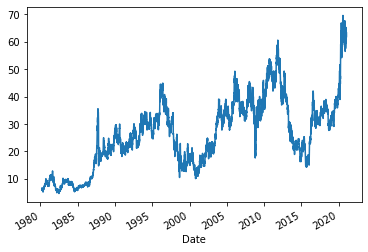

In [265]:
# a quick preview of closing price data
hist['Close'].plot();

#### Making a loop for mass extraction

Once the above was confirmed, we defined a loop to mass extract data.

In [266]:
# mass scrapping loop function
fail_tickers = []
def price_scrape_loop(ticker, name, sector, industry):
    try:
        print('trying', ticker)
        target_ticker = yf.Ticker(ticker)

        # get historical market data
        hist = target_ticker.history(period="max")
        
        # adding columns
        hist['ticker'] = ticker
        hist['name'] = name
        hist['sector'] = sector
        hist['industry'] = industry

    except:
        print('fail', ticker)
        fail_tickers.append(ticker)
        pass
    return hist

In [278]:
# gathering the identification info for each comp from respective portfolio
combined_name_list = domain_df.name.tolist() + kmeans_portfolio.name.tolist()
combined_sector_list = domain_df.sector.tolist() + kmeans_portfolio.sector.tolist()
combined_industry_list = domain_df.industry.tolist() + kmeans_portfolio.industry.tolist()

# call the function, iterate for all tickers, append each ticker result to one df
i = 0
zip_list = zip(combined_ticker_list, combined_name_list, combined_sector_list, combined_industry_list)

for ticker, name, sector, industry in zip_list:
    if i==0:
        all_comp_df = price_scrape_loop(ticker, name, sector, industry)
        i+=1
    else:
        all_comp_df = all_comp_df.append(price_scrape_loop(ticker, name, sector, industry))
    
    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(2,3)
    ntime.sleep(sleep_duration)
    print('Success', ticker, 'sleep', sleep_duration)

trying ABBV
Success ABBV sleep 2
trying CAG
Success CAG sleep 2
trying CSCO
Success CSCO sleep 3
trying GSK
Success GSK sleep 3
trying LMT
Success LMT sleep 2
trying MRK
Success MRK sleep 2
trying RCI
Success RCI sleep 3
trying TRP
Success TRP sleep 3
trying VALE
Success VALE sleep 3
trying VZ
Success VZ sleep 3
trying ABT
Success ABT sleep 2
trying AJG
Success AJG sleep 2
trying DG
Success DG sleep 2
trying FBHS
Success FBHS sleep 3
trying FMC
Success FMC sleep 3
trying LDOS
Success LDOS sleep 2
trying MGA
Success MGA sleep 2
trying NEM
Success NEM sleep 3
trying PWR
Success PWR sleep 2
trying SAP
Success SAP sleep 2


**NOTE: The error message above (if any) was due to a manual interruption to the code execution. The codes work perfectly, it was manually interrupted because we have to run this notebook again to generate the in-notebook visuals to go with the textual explanation of how this works. The desire results were obtained and exported to CSV files for subsequent steps.**

In [279]:
# checking if any tickers failed
print('Failed tickers = ', fail_tickers)

Failed tickers =  []


**NOTE: The "Failed tickers" (if any) reported above was due to a manual interruption to the code execution. The codes work perfectly, it was manually interrupted because we have to run this notebook again after a kernel refresh to generate the in-notebook visuals to go with the textual explanation of how this works. The desire results (with no fail tickers) were obtained in previous full run and were exported to CSV files for subsequent steps.**

**NOTE: Some codes below are commented out to prevent accidental execution that will overwrite the previously extracted data used for the rest of this project.**

In [281]:
# exporting result to csv file as backup
#all_comp_df.to_csv('datasets/daily_history_prices.csv')

In [282]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#all_comp_df.to_csv('datasets/backups/daily_history_prices.csv')

In [ ]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
#all_comp_df = pd.read_csv('datasets/backups/daily_history_prices.csv')

#### Data Cleaning and EDA

In [3]:
# read in last good backup file
daily_adj_prices_df = pd.read_csv('datasets/backups/daily_history_prices.csv')
print(daily_adj_prices_df.shape)
daily_adj_prices_df.sample(frac=1).head()

(154691, 12)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,name,sector,industry
139025,2007-02-15,37.200028,37.312223,36.903518,37.272152,4202300.0,0.0,0.0,NEM,Newmont Corporation,Basic Materials,Gold
73561,2014-11-06,7.691131,7.691131,7.454355,7.462520,26317500.0,0.0,0.0,VALE,Vale S.A.,Basic Materials,Other Industrial Metals & Mining
43254,1976-10-27,0.507524,0.510144,0.504903,0.510144,950400.0,0.0,0.0,MRK,"Merck & Co., Inc.",Healthcare,Drug Manufacturers - General
69342,2016-12-07,35.279012,35.913101,35.088787,35.913101,619100.0,0.0,0.0,TRP,TC Energy Corporation,Energy,Oil & Gas Midstream
34528,1993-04-06,9.401828,9.477042,9.383024,9.477042,192600.0,0.0,0.0,LMT,Lockheed Martin Corporation,Industrials,Aerospace & Defense


In [4]:
# check for NaN
daily_adj_prices_df.isnull().sum()

Date            0
Open            4
High            4
Low             4
Close           4
Volume          4
Dividends       0
Stock Splits    0
ticker          0
name            0
sector          0
industry        0
dtype: int64

In [5]:
# investigate NaN
daily_adj_prices_df[daily_adj_prices_df.Close.isnull()]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,name,sector,industry
10260,2012-10-29,NaN,NaN,NaN,NaN,NaN,0.25,0.0,CAG,"Conagra Brands, Inc.",Consumer Defensive,Packaged Foods
35452,1996-11-28,NaN,NaN,NaN,NaN,NaN,0.40,0.0,LMT,Lockheed Martin Corporation,Industrials,Aerospace & Defense
127035,2000-05-29,NaN,NaN,NaN,NaN,NaN,0.30,0.0,MGA,Magna International Inc.,Consumer Cyclical,Auto Parts
141998,2018-12-05,NaN,NaN,NaN,NaN,NaN,0.14,0.0,NEM,Newmont Corporation,Basic Materials,Gold


In [6]:
# dropping NaN rows since only 4, coming from different companies and dates are very spread out
daily_adj_prices_df.dropna(axis=0, inplace=True)
print(daily_adj_prices_df.shape)
daily_adj_prices_df.isnull().sum()

(154687, 12)


Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
ticker          0
name            0
sector          0
industry        0
dtype: int64

In [7]:
# check datatypes
daily_adj_prices_df.dtypes

Date             object
Open            float64
High            float64
Low             float64
Close           float64
Volume          float64
Dividends       float64
Stock Splits    float64
ticker           object
name             object
sector           object
industry         object
dtype: object

In [8]:
# correcting datetime
daily_adj_prices_df['Date'] = pd.to_datetime(daily_adj_prices_df['Date'])
daily_adj_prices_df['Date']

0        2013-01-02
1        2013-01-03
2        2013-01-04
3        2013-01-07
4        2013-01-08
            ...    
154686   2021-01-15
154687   2021-01-19
154688   2021-01-20
154689   2021-01-21
154690   2021-01-22
Name: Date, Length: 154687, dtype: datetime64[ns]

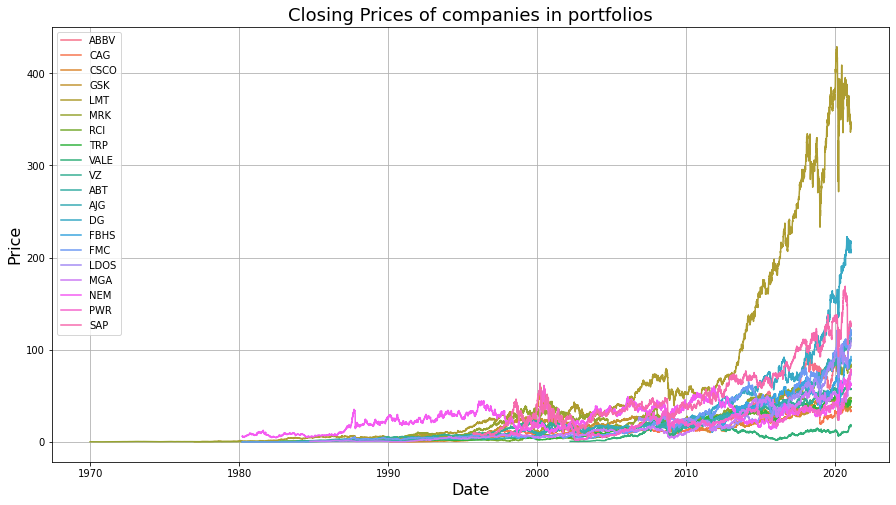

In [16]:
# visualizing prices of all companies in portfolios
plt.figure(figsize=(15,8), facecolor='white')

# Printing and plotting those predictions
sns.lineplot(x=daily_adj_prices_df.Date, y=daily_adj_prices_df.Close, hue='ticker', data=daily_adj_prices_df,
             estimator=None)

plt.title(f'Closing Prices of companies in portfolios', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.legend()
plt.grid()
plt.show()

**Note:** We can see that there is a good spread of price ranges for the companies in our portfolios. There are periods of uptrend and downtrend. Company "LMT" seems to be the odd one out with very high price growth over the years. A quick check against the finviz.com website confirms that the trend is true and it is not a data error.

In [9]:
# final view before export
daily_adj_prices_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,name,sector,industry
0,2013-01-02,24.597448,24.935559,24.019845,24.738327,13767900.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
1,2013-01-03,24.653801,24.653801,24.062110,24.534056,16739300.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
2,2013-01-04,24.386131,24.576318,24.125506,24.224121,21372100.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
3,2013-01-07,24.055067,24.970780,24.055067,24.273428,17897100.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,2013-01-08,24.153686,24.400223,23.498599,23.745136,17863300.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
...,...,...,...,...,...,...,...,...,...,...,...,...
154686,2021-01-15,125.529999,126.349998,124.360001,125.000000,1564300.0,0.0,0.0,SAP,SAP SE,Technology,Software - Application
154687,2021-01-19,126.459999,127.250000,125.239998,127.080002,892400.0,0.0,0.0,SAP,SAP SE,Technology,Software - Application
154688,2021-01-20,126.739998,128.029999,126.629997,127.629997,917100.0,0.0,0.0,SAP,SAP SE,Technology,Software - Application
154689,2021-01-21,127.599998,128.130005,126.820000,127.900002,797500.0,0.0,0.0,SAP,SAP SE,Technology,Software - Application


In [105]:
# exporting result to csv file as backup
#daily_adj_prices_df.to_csv('datasets/cleaned_daily_adj_prices_df.csv', index=False)

In [106]:
# DO NOT run this section unless necessary
# i.e. only run this after a full fresh pull of data to create a new backup file
# otherwise it will overwrite the previous backup file used for processing in other notebook

# exporting result to csv file as backup
#daily_adj_prices_df.to_csv('datasets/backups/cleaned_daily_adj_prices_df.csv', index=False)

In [107]:
# run this code if there is an accidental refresh of kernel to import the backup file
# import backup file to csv
#daily_adj_prices_df = pd.read_csv('datasets/backups/cleaned_daily_adj_prices_df.csv')

# END OF NOTEBOOK

With all the require data collected, cleaned and exported to CSV files. We are ready to move into the next stage of Modeling and Tuning. To the next notebook...